# TODO I have new doubts that the order of the DF is in keeping with the order of the spectrograms, which is critical
# TODO I have to verify/fix this, and ideally I would link these things so that they can't be wrong as easily.
## Read biosound H5 files and cluster
### After sorting some syllables/notes/calls in SoundSep you must first calculate spectral/temporal features of them with Biosound and store those features as H5 files. This is all done with save_biosound_h5files.ipynb.
### This notebook takes the H5 files, makes a Pandas DF, and does some clustering on them.

In [37]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA



# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(2, 2))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

In [3]:
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023"# _Maeves_data"
h5_folder = 'h5filesAmp'

fs = 48000 # TODO find where to import fs instead of hardcoding it

os.chdir(os.path.join(base_folder, h5_folder))
print(os.getcwd())
files_list = os.listdir('.')
print(f'num files = {len(files_list)}, files_list[0] = {files_list[0]}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/h5filesAmp
num files = 4345, files_list[0] = bird_WhiWhi6607F_call_["0"]_1134.h5


In [4]:
# Testing with one file
fname = files_list[1]

myBioSound = BioSound()
myBioSound.readh5(fname)
        
# Take the time average formants 
meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
# These are our two identifier - the emitter (bird) and the call type
Bird = np.array2string(myBioSound.emitter)[2:-1]
callType = np.array2string(myBioSound.type)[2:-1]

print("The following values shouldn't be NaN or 0")
print(f'meanF1 = {meanF1}, meanF2 = {meanF2}, meanF3 = {meanF3}, Bird = {Bird}, callType = {callType}')

The following values shouldn't be NaN or 0
meanF1 = 1223.1475918116207, meanF2 = 4405.922739456839, meanF3 = 9015.34493500762, Bird = BluGre1214F, callType = ["6"]


## If you have previously saved a pandas df from the H5 files you can skip the next two cells
# in many ways however this is the meat of this notebook

In [5]:
# # vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
# vocSelData = []

# # Looping through all the files
# i = 0
# for fname in files_list:
#     if fname.endswith('.h5'):
#         # print(f'index = {i}, fname = {fname}')
#         # print(fname)
#         # Allocate object and read data
#         myBioSound = BioSound()
#         try:
#             myBioSound.readh5(fname)
#         except:
#             print('Could not read h5 file', fname)
#             continue
        
#         # These are our two identifier - the emitter (bird) and the call type
#         Bird = np.array2string(myBioSound.emitter)[2:-1]
#         callType = np.array2string(myBioSound.type)[2:-1]

#         # Get values for the fundamental
#         if myBioSound.fund.size > 0:
#             fund = float(myBioSound.fund)
#             cvfund = float(myBioSound.cvfund)
#             maxfund = float(myBioSound.maxfund)
#             minfund = float(myBioSound.minfund)
#             devfund = np.nanmean(np.diff(myBioSound.f0))
#                     # Take the time average formants 
#             meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
#             meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
#             meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
#         else:
#             fund = -10 
#             cvfund = 0   
#             maxfund = 0
#             # TODO add default value of devfund
#             # TODO just notes here: play with UMAP neighborhood.
#             # TODO play with HDBScan neighborhood. fit it. silhouette score. davis dun score. 
#             # TODO # of unclassified calls.
#             # TODO try to classifiy noise vs calls. force 2 clusters.
#             # then look at soundsep. 
#             minfund = 0
#             devfund = 0
#             meanF1 = 0
#             meanF2 = 0
#             meanF3 = 0
            

#         vocSelData.append({"Bird": Bird, 
#                      "project.start_index": int(fname.split('.')[0].split('_')[-1]),
#                      "calltype": callType, 
#                      "fund": fund, "devfund": devfund,
#                      "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
#                      "F1": meanF1, "F2": meanF2, "F3":meanF3,
#                      "sal": float(myBioSound.meansal), 
#                      "rms": float(myBioSound.rms), 
#                      "maxAmp": float(myBioSound.maxAmp),
#                      "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
#                      "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
#                      "entS": float(myBioSound.entropyspect),
#                      "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
#                      "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
#                      "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
#                      "entT": float(myBioSound.entropytime)
        
# })
#         i += 1
#         if ((i % 1000) == 0):
#             print('Done with', i, 'files')
#         #if (i == 10000):
#             #break

# print(f'Done with {i} files')


In [6]:
# Write the results to a pandas df

# tableStore = os.path.join(base_folder,'vocSelTableAmp.h5')
# vocSelTable = pd.DataFrame(vocSelData)
# vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')

## If you already stored the H5 file just load it, skipping the above cells
## Either way, at this point we will also need to load the soundsep syllable csv from a couple steps up the pipeline

In [7]:
# You can also start the script here and skip the reading of h5 files and creation of table
# Read the vocSelTable
vocSelTable = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # 
print(f"loading file: {os.path.join(base_folder, 'vocSelTableAmp.h5')} with {len(vocSelTable)} syllables")

loading file: /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/vocSelTableAmp.h5 with 4344 syllables


In [8]:
# Read the annotated syllabes.csv (soundsep metadata) to get information on solo vs overlap and what tags were manually entered
syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
backup_name = os.path.join(base_folder,'_appdata','save','segments_backup_good.csv')
syllTable = pd.read_csv(backup_name, sep=',',header=0) 
print(f"loading {syll_file_name} with {len(syllTable)} syllables")

birds = np.unique(vocSelTable['Bird'])
print(f'birds = {birds}')

loading /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv with 4344 syllables
birds = ['BluGre1214F' 'BroGre1354M' 'WhiWhi1541M' 'WhiWhi6607F']


In [9]:
# Now we merge the syllTable (soundsep metadata) and the vocSelTable (biosound features).TextDisplayObject
# The indices ARE NOT THE SAME, so we can't just merge the tables on the index
# the index of vocSelTable is 'project.start_index' column
# and the index of syllTable is the index
# TODO FOR GODS SAKE THE INDICES ARE STILL BROKEN PAY ATTENTION TO THIS

# might as well check if the indices are the same while I'm at it
if np.array_equal(vocSelTable.index, syllTable.index):
    # sort vocSelTable by 'project.start_index' column
    vocSelTable = vocSelTable.sort_values(by='project.start_index')

    # make the index of vocSelTable the 'project.start_index' column
    vocSelTable.index = vocSelTable['project.start_index'].values
    # # drop the 'project.start_index' column
    vocSelTable = vocSelTable.drop(columns=['project.start_index'])
    vocSelTableFull = pd.merge(vocSelTable, syllTable, left_index=True, right_index=True)

    # also sort the files_list by 'project.start_index' column
    files_list = [[f, int(f.split('.')[0].split('_')[-1])] for f in files_list if f.endswith('.h5')]
    files_list = pd.DataFrame(files_list, columns=['file', 'project.start_index'])
    files_list = files_list.sort_values(by='project.start_index')
    files_list.index = files_list['project.start_index'].values
    files_list = files_list['file']

else:
    print('The indices are not the same this is a problem, a big problem')
vocSelTableFull

Bird calltype        fund   devfund    cvfund     maxfund  \
0     BroGre1354M    ["1"]  508.574590 -0.740855  0.045986  527.472527   
1     BluGre1214F    ["6"]  523.880794 -1.720430  0.011674  533.333333   
2     BluGre1214F    ["2"]  548.575055 -2.208039  0.027101  564.705882   
3     BluGre1214F    ["6"]  557.333804 -2.713336  0.036705  592.592593   
4     BroGre1354M    ["5"]  560.232975 -0.867444  0.035327  578.313253   
...           ...      ...         ...       ...       ...         ...   
4339  WhiWhi1541M    ["5"]  518.037891 -1.209025  0.040681  539.325843   
4340  BluGre1214F    ["6"]  536.911375  0.723694  0.153731  592.592593   
4341  BluGre1214F    ["6"]  567.024101  0.350191  0.102408  600.000000   
4342  BluGre1214F    ["6"]  557.353786  0.768246  0.171243  615.384615   
4343  WhiWhi1541M    ["5"]  549.016050 -1.051440  0.051059  578.313253   

         minfund           F1           F2           F3  ...     skewT  \
0     436.363636  1664.044399  3561.528246  8596.893613  ...  0.071239   
1     516.129032  3271.703942  6280.586421  9217.829837  ... -0.166511   
2     516.129032  4135.587818  9121.142787          NaN  ...  0.066682   
3     527.472527  3192.273235  6348.161057  9158.343416  ... -0.398596   
4     516.129032  2570.895759  4398.845756  9123.647713  ...  0.238298   
...          ...          ...          ...          ...  ...       ...   
4339  475.247525  1927.627306  3946.935002  9088.130784  ...  0.049641   
4340  298.136646  1827.897792  4833.507703  8912.761732  ... -0.111108   
4341  296.296296  1765.890567  4526.155286  8829.029019  ...  0.063799   
4342  290.909091  1829.396367  4179.381920  8804.060975  ...  0.368920   
4343  489.795918  1623.441547  4200.259348  8997.675394  ...  0.074128   

         kurtT      entT  Unnamed: 0   SourceName  SourceChannel  StartIndex  \
0     1.959314  0.989150           0  BroGre1354M              0      705034   
1     2.109855  0.986979           1  BluGre1214F              2      739121   
2     2.189062  0.960172           2  BluGre1214F              2      773851   
3     2.201422  0.982954           3  BluGre1214F              2      844891   
4     2.304452  0.976569           4  BroGre1354M              0      910549   
...        ...       ...         ...          ...            ...         ...   
4339  2.036406  0.990364        4339  WhiWhi1541M              3   297302736   
4340  1.979158  0.989058        4340  BluGre1214F              2   297324812   
4341  1.894907  0.994484        4341  BluGre1214F              2   297367001   
4342  2.121620  0.974212        4342  BluGre1214F              2   298070022   
4343  1.997225  0.991150        4343  WhiWhi1541M              3   298089447   

      StopIndex   Tags  cluster  
0        709502  ["1"]      0.0  
1        741816  ["6"]      5.0  
2        776369  ["2"]      1.0  
3        848558  ["6"]      5.0  
4        913839  ["5"]      4.0  
...         ...    ...      ...  
4339  297305283  ["5"]      4.0  
4340  297329004  ["6"]      5.0  
4341  297371644  ["6"]      5.0  
4342  298074525  ["6"]      5.0  
4343  298092579  ["5"]      4.0  

[4344 rows x 33 columns]

['["1"]' '["6"]' '["2"]' '["5"]' '["0"]' '["4"]' '["3"]' '[]']
['1' '6' '2' '5' '0' '4' '3' '']


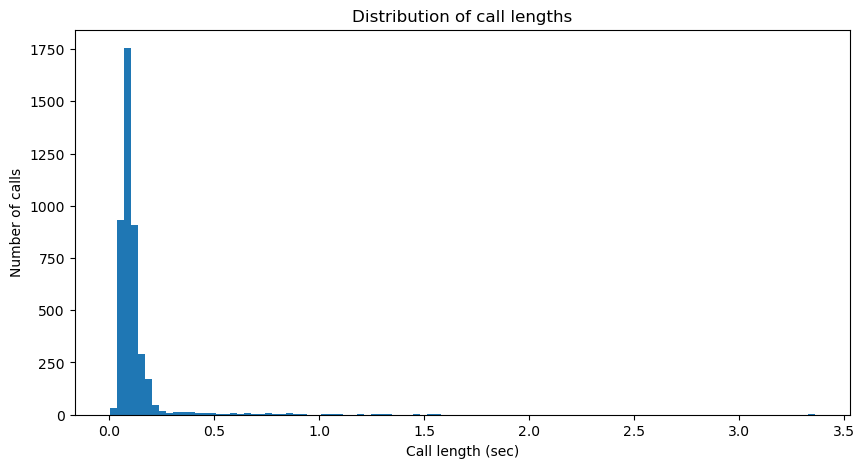

In [10]:
# calculate the length of each call
vocSelTableFull['callLength'] = (vocSelTableFull['StopIndex'] - vocSelTableFull['StartIndex']) / fs
 
# plot the distribution of call lengths
plt.figure(figsize=(10, 5))
plt.hist(vocSelTableFull['callLength'], bins=100)
plt.xlabel('Call length (sec)')
plt.ylabel('Number of calls')
plt.title('Distribution of call lengths')

# The tags have extra characters that I don't want
print(vocSelTableFull['Tags'].unique())
# it appears they have a '[""]' surrounding them
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')
print(vocSelTableFull['Tags'].unique())
# change the tags column of the df to the stripped version
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')

## Now we are going to rearrange the data to do a UMAP projection.
## This requires:
## - taking only some features
## - excluding any rows with NaNs
## - zscore and then calculate PCAs
## - we may also may withhold some data to verify our sorting (not now though)

# I think this is working now but if you want to worry about something you can worry about the finding of bad features in the next two cells, or the index of feature names that's coded by column integer...

In [11]:
# Generate the data array of biosound features
# X is the data array of features.
startFeat = 2
endFeat = 9
startFeat2 = 10
endFeat2 = 26
# note I added callLength to the features, which is the last one
# salInd = 6 # saliency index, I don't think this is good to exclude by

XFeatureNames = np.array(np.hstack((vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:])))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)

Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']


In [12]:
# Generate the data array of biosound features
# X is the data array of features.


XBirds = []
indGoodBirds = []
infoBirds = []
nsyllBirds = []
    
X = np.hstack([vocSelTableFull.iloc[:,startFeat:endFeat],vocSelTableFull.iloc[:,startFeat2:endFeat2],vocSelTableFull.iloc[:,-1:]])

# Find the rows that have the full data set

# I was excluding by saliency, but I don't think this is a good idea
# indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures) & (X[:,salInd]>0.3))[0]
# indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures) | (X[:,salInd]<=0.3))[0]
indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures))[0]
indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures))[0]
# print(f'badfiles = {indBad}')
indGoodBirds.append(indGood)

# print('nsyll=', len(indGood), '/', X.shape[0])
nsyllBirds.append(len(indGood))
# How many rows are we losing?
print('Number of rows lost:', X.shape[0] - len(indGood))
print('Out of how many rows?', X.shape[0])

# # calculate which features are contributing to the missing data
def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

print_missing_features(X, XFeatureNames, indBad)

cleanX = X[indGood,:]
cleanTags = vocSelTableFull.iloc[indGood,0:3]
print('dimensions of cleanX:', cleanX.shape)
# print cleantages unique
print('unique call types:', np.unique(cleanTags['calltype']))


Number of rows lost: 4
Out of how many rows? 4344
num missing devfund = 2
num missing F2 = 2
dimensions of cleanX: (4340, 24)
unique call types: ['["0"]' '["1"]' '["2"]' '["3"]' '["4"]' '["5"]' '["6"]' '[]']


In [13]:
# print the names of h5 files with bad indexes
for ind in indBad[0:10]:
    print(f"bad files names = {files_list[ind]}, index = {ind}")

bad files names = bird_WhiWhi1541M_call_["0"]_468.h5, index = 468
bad files names = bird_WhiWhi1541M_call_["0"]_913.h5, index = 913
bad files names = bird_WhiWhi6607F_call_[]_1443.h5, index = 1443
bad files names = bird_BluGre1214F_call_["0"]_2727.h5, index = 2727


Shape of Z_PCA_All: (4340, 10)


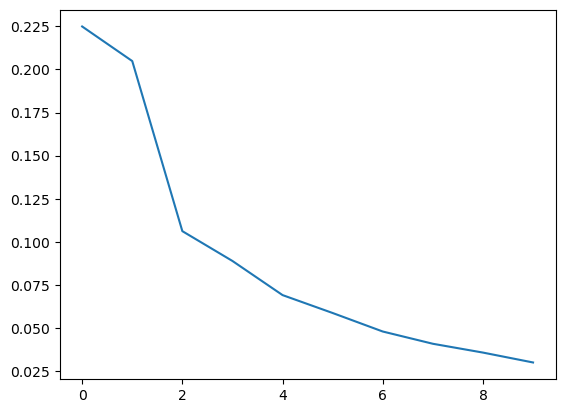

In [14]:
# Zscore the data
meanBalancedAll = np.mean(cleanX, axis = 0)
sdBalancedAll = np.std(cleanX, axis = 0, ddof=1)
ZBalancedAll = (cleanX - meanBalancedAll)/sdBalancedAll

# PCA the data
pcaBalanced = PCA(n_components=10, svd_solver='full')
Z_PCA_Balanced_All = pcaBalanced.fit_transform(ZBalancedAll)

print("Shape of Z_PCA_All:", Z_PCA_Balanced_All.shape)

# Plot the explainable variance
plt.plot(pcaBalanced.explained_variance_ratio_)

(4340, 10)


Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

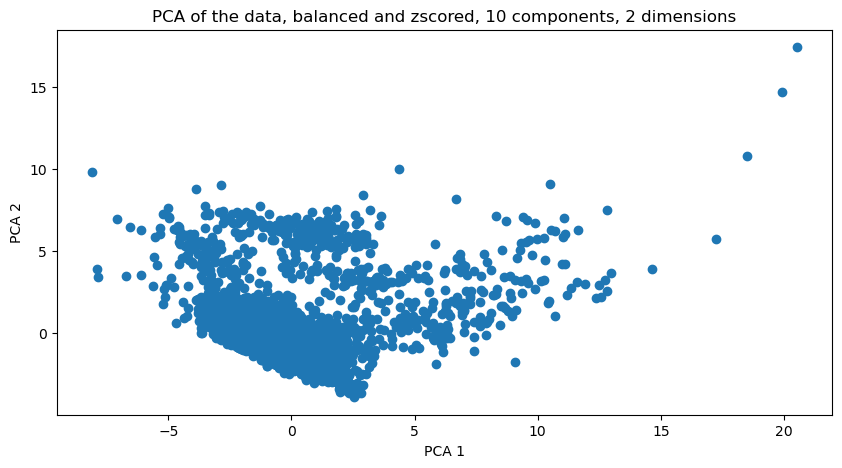

In [15]:
print(Z_PCA_Balanced_All.shape)
# Plot the first two components
plt.figure(figsize=(10, 5))
plt.scatter(Z_PCA_Balanced_All[:,0], Z_PCA_Balanced_All[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')


In [16]:
# Take the z-scored PCA data and run UMAP on it

MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)

# umapAllData = umapFit.transform(Z_PCA_Balanced_All)

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [17]:
# unique tags
print('unique tags:', np.unique(cleanTags['calltype']))


unique tags: ['["0"]' '["1"]' '["2"]' '["3"]' '["4"]' '["5"]' '["6"]' '[]']


Text(0.5, 1.0, 'UMAP colored by soundsep defined call type')

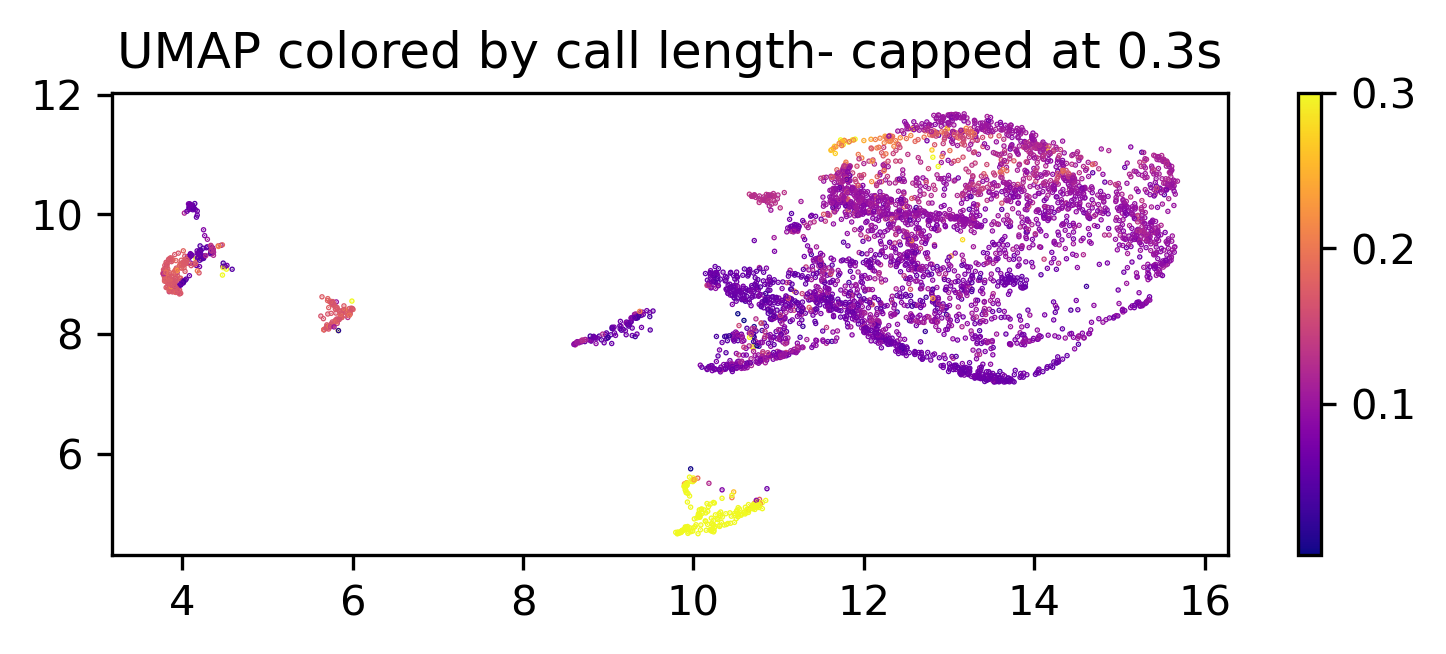

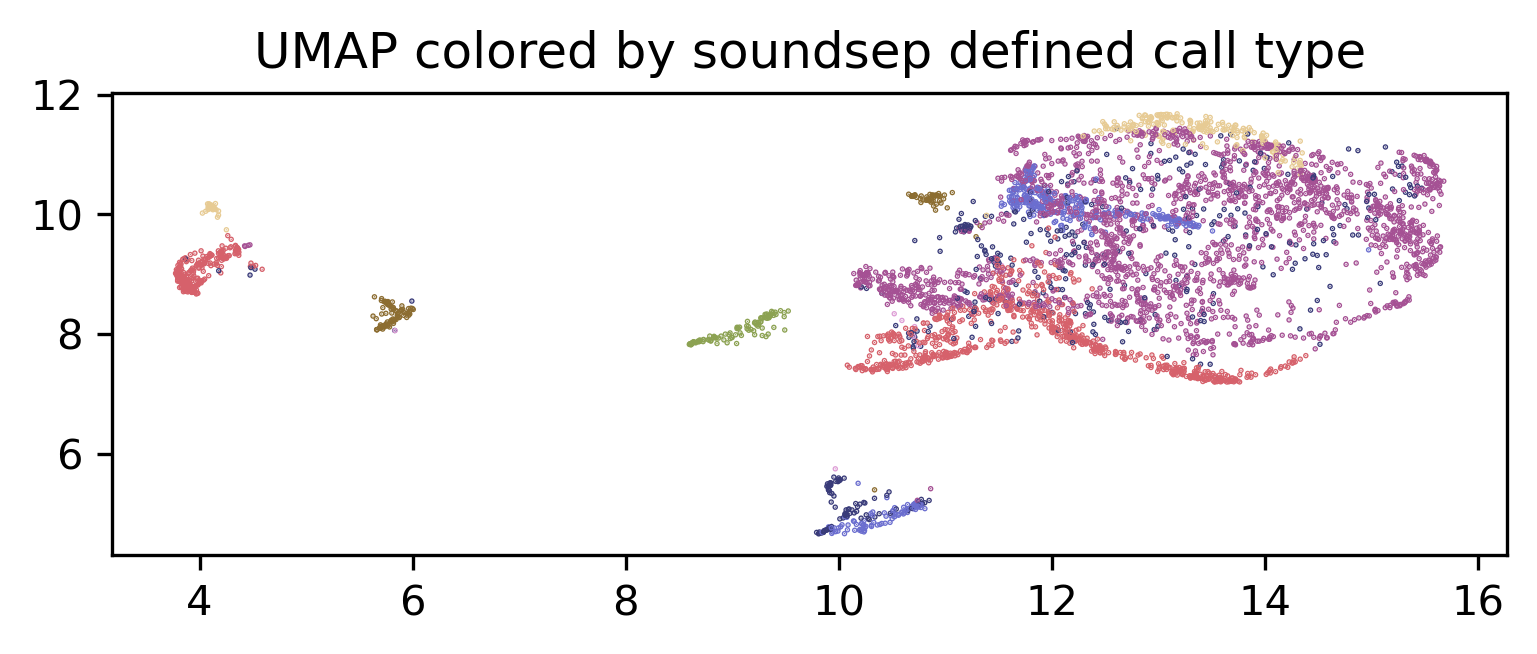

In [18]:
# shift the color index so that 0-.5s contains most of the color range.
# and plot the umap

c=cleanX[:,-1]
c[c>.3]=.3
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=c, cmap='plasma')
plt.title('UMAP colored by call length- capped at 0.3s')
plt.colorbar()

# plot the UMAP and color by the original tags of the call type
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=cleanTags['calltype'].astype('category').cat.codes, cmap='tab20b')
plt.title('UMAP colored by soundsep defined call type')



In [19]:
# Let's cluster the UMAP data
# HDBSCAN
min_cluster_size = 15
min_samples = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
clusterer.fit(umapAll)


HDBSCAN(min_cluster_size=15, min_samples=15)

seems like my segments.csv file already has tags, figure this out

## Now let's use some clustering algorithms to assign new tags to our data.
## Afterwards we can re-save the SoundSep tags and look at the syllables there

Counter({-1: 1474, 6: 295, 5: 260, 14: 186, 15: 175, 3: 150, 20: 130, 22: 117, 30: 116, 21: 110, 1: 102, 0: 89, 18: 84, 36: 80, 16: 78, 10: 69, 26: 69, 39: 66, 38: 58, 12: 56, 27: 54, 9: 49, 8: 43, 32: 40, 31: 34, 25: 31, 4: 30, 2: 30, 40: 29, 29: 22, 28: 21, 23: 21, 24: 20, 35: 18, 34: 18, 7: 18, 37: 18, 11: 17, 17: 16, 13: 16, 33: 16, 19: 15})


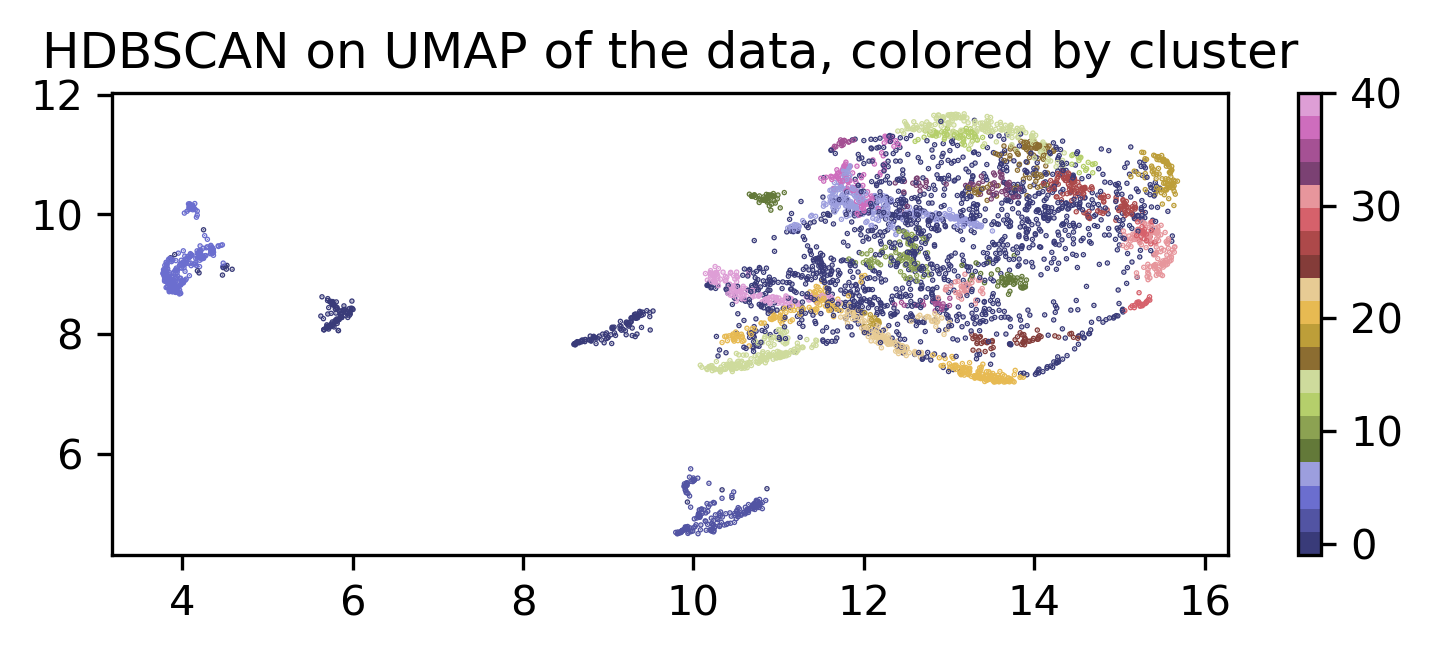

In [20]:
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()

#print the number data points in each cluster
print(Counter(clusterer.labels_))

In [21]:
# print the number of calls in each cluster and the unclassified
print('Number of calls in each cluster and the unclassified')
print(Counter(clusterer.labels_))



Number of calls in each cluster and the unclassified
Counter({-1: 1474, 6: 295, 5: 260, 14: 186, 15: 175, 3: 150, 20: 130, 22: 117, 30: 116, 21: 110, 1: 102, 0: 89, 18: 84, 36: 80, 16: 78, 10: 69, 26: 69, 39: 66, 38: 58, 12: 56, 27: 54, 9: 49, 8: 43, 32: 40, 31: 34, 25: 31, 4: 30, 2: 30, 40: 29, 29: 22, 28: 21, 23: 21, 24: 20, 35: 18, 34: 18, 7: 18, 37: 18, 11: 17, 17: 16, 13: 16, 33: 16, 19: 15})


In [35]:
len(np.unique(clusterer.labels_))

42

cluster_num = -1
raw file name = bird_BluGre1214F_call_["6"]_5.h5
reading a spectrogram from BluGre1214F_["6"]_915664_917825.wav
w is lenght 2161


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


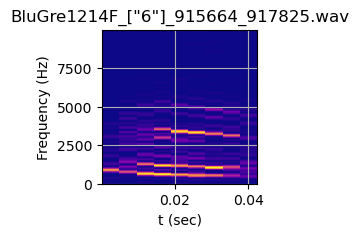


  
raw file name = bird_BluGre1214F_call_["6"]_7.h5
reading a spectrogram from BluGre1214F_["6"]_955388_958960.wav
w is lenght 3572


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


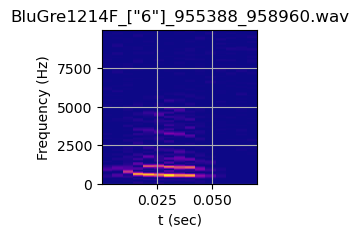


  
raw file name = bird_BluGre1214F_call_["0"]_8.h5
reading a spectrogram from BluGre1214F_["0"]_982338_984912.wav
w is lenght 2574


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


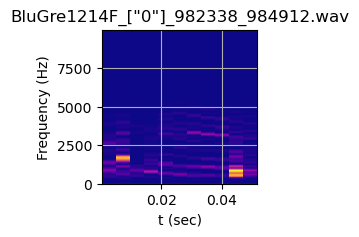


  
raw file name = bird_BluGre1214F_call_["6"]_11.h5
reading a spectrogram from BluGre1214F_["6"]_1246128_1249389.wav
w is lenght 3261


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


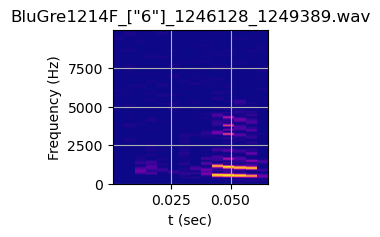


  
cluster_num = 0
raw file name = bird_BroGre1354M_call_["0"]_142.h5
reading a spectrogram from BroGre1354M_["0"]_8027882_8047791.wav
w is lenght 19909


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


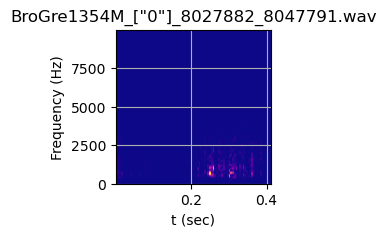


  
raw file name = bird_BroGre1354M_call_["3"]_346.h5
reading a spectrogram from BroGre1354M_["3"]_23061869_23070045.wav
w is lenght 8176


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


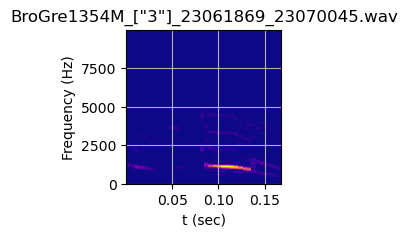


  
raw file name = bird_BroGre1354M_call_["3"]_361.h5
reading a spectrogram from BroGre1354M_["3"]_23197434_23206727.wav
w is lenght 9293


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


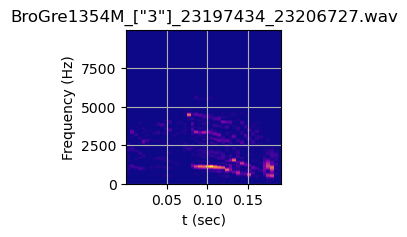


  
raw file name = bird_BluGre1214F_call_["6"]_497.h5
reading a spectrogram from BluGre1214F_["6"]_27310734_27317156.wav
w is lenght 6422


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


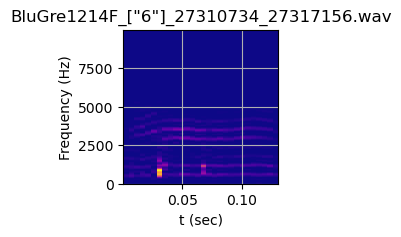


  
cluster_num = 1
raw file name = bird_BluGre1214F_call_["2"]_2.h5
reading a spectrogram from BluGre1214F_["2"]_773851_776369.wav
w is lenght 2518


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


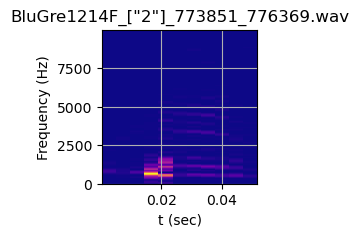


  
raw file name = bird_BluGre1214F_call_["2"]_15.h5
reading a spectrogram from BluGre1214F_["2"]_1487256_1490333.wav
w is lenght 3077


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


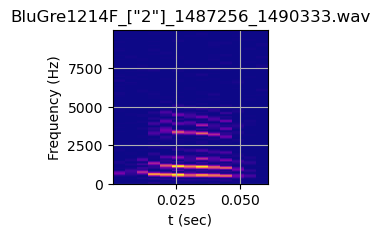


  
raw file name = bird_BluGre1214F_call_["2"]_93.h5
reading a spectrogram from BluGre1214F_["2"]_6750316_6753014.wav
w is lenght 2698


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


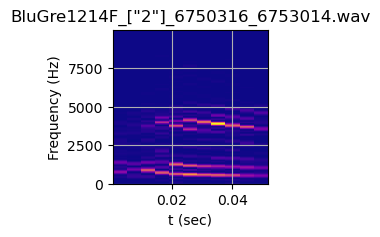


  
raw file name = bird_BluGre1214F_call_["2"]_95.h5
reading a spectrogram from BluGre1214F_["2"]_6770992_6773967.wav
w is lenght 2975


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


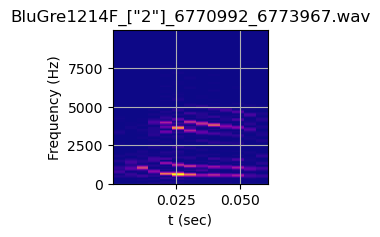


  
cluster_num = 2
raw file name = bird_WhiWhi1541M_call_["0"]_400.h5
reading a spectrogram from WhiWhi1541M_["0"]_24294505_24304237.wav
w is lenght 9732


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


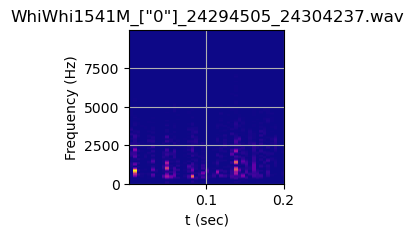


  
raw file name = bird_WhiWhi1541M_call_["0"]_418.h5
reading a spectrogram from WhiWhi1541M_["0"]_24524353_24542880.wav
w is lenght 18527


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


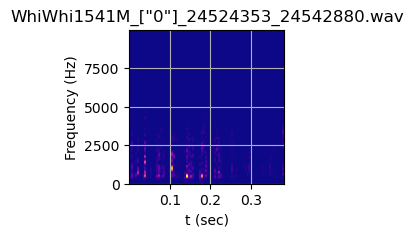


  
raw file name = bird_WhiWhi1541M_call_["0"]_427.h5
reading a spectrogram from WhiWhi1541M_["0"]_24620213_24635132.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 14919


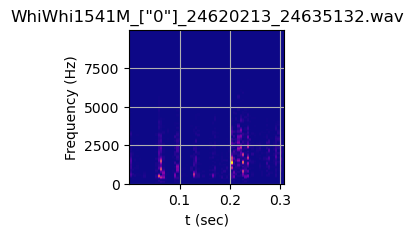


  
raw file name = bird_BluGre1214F_call_["0"]_448.h5
reading a spectrogram from BluGre1214F_["0"]_25570324_25587297.wav
w is lenght 16973


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


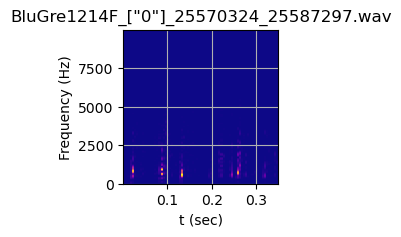


  
cluster_num = 3
raw file name = bird_WhiWhi6607F_call_["1"]_112.h5
reading a spectrogram from WhiWhi6607F_["1"]_7072234_7100699.wav
w is lenght 28465


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


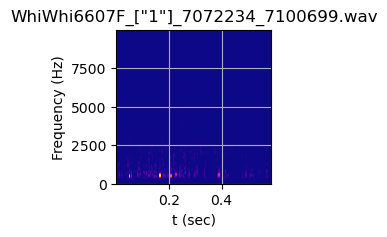


  
raw file name = bird_BroGre1354M_call_["1"]_150.h5
reading a spectrogram from BroGre1354M_["1"]_8196745_8230327.wav
w is lenght 33582


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


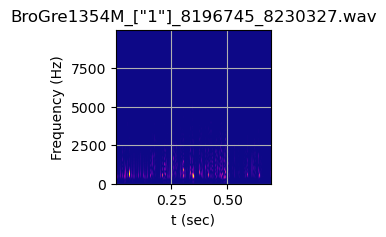


  
raw file name = bird_BroGre1354M_call_["0"]_180.h5
reading a spectrogram from BroGre1354M_["0"]_8685663_8694128.wav
w is lenght 8465


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


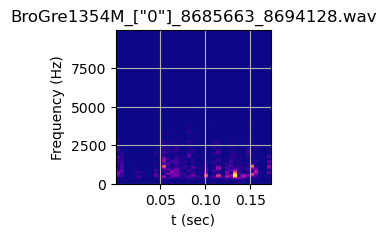


  
raw file name = bird_WhiWhi6607F_call_["1"]_184.h5
reading a spectrogram from WhiWhi6607F_["1"]_8753718_8770676.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 16958


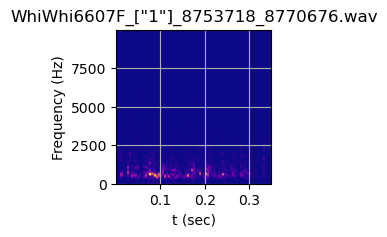


  
cluster_num = 4
raw file name = bird_BroGre1354M_call_["4"]_350.h5
reading a spectrogram from BroGre1354M_["4"]_23100463_23106126.wav
w is lenght 5663


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


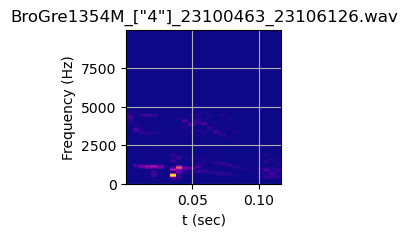


  
raw file name = bird_WhiWhi1541M_call_["0"]_735.h5
reading a spectrogram from WhiWhi1541M_["0"]_34295350_34310285.wav
w is lenght 14935


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


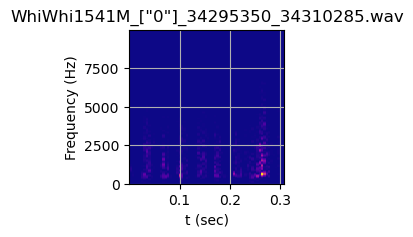


  
raw file name = bird_BluGre1214F_call_["6"]_1154.h5
reading a spectrogram from BluGre1214F_["6"]_57694811_57698734.wav
w is lenght 3923


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


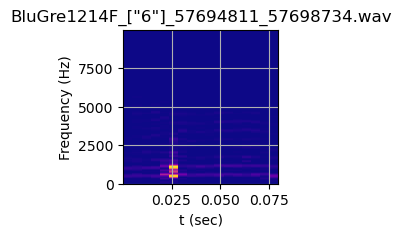


  
raw file name = bird_BroGre1354M_call_["3"]_1155.h5
reading a spectrogram from BroGre1354M_["3"]_57734090_57742416.wav
w is lenght 8326


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


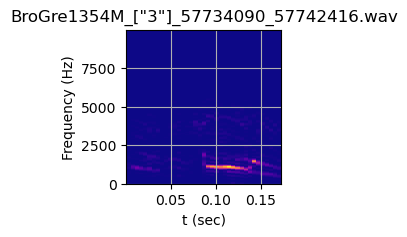


  
cluster_num = 5
raw file name = bird_BluGre1214F_call_["5"]_56.h5
reading a spectrogram from BluGre1214F_["5"]_4838951_4842034.wav
w is lenght 3083


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


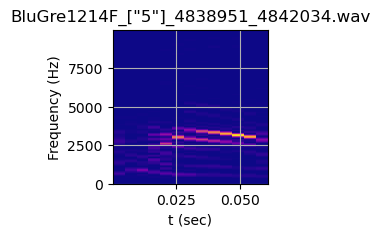


  
raw file name = bird_BluGre1214F_call_["5"]_210.h5
reading a spectrogram from BluGre1214F_["5"]_9409312_9412258.wav
w is lenght 2946


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


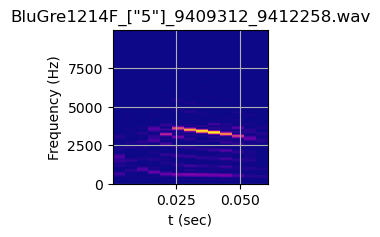


  
raw file name = bird_BluGre1214F_call_["5"]_213.h5
reading a spectrogram from BluGre1214F_["5"]_9454102_9456811.wav
w is lenght 2709


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


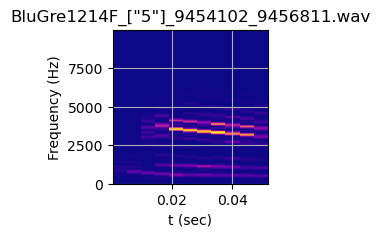


  
raw file name = bird_BluGre1214F_call_["5"]_247.h5
reading a spectrogram from BluGre1214F_["5"]_10202548_10205480.wav
w is lenght 2932


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


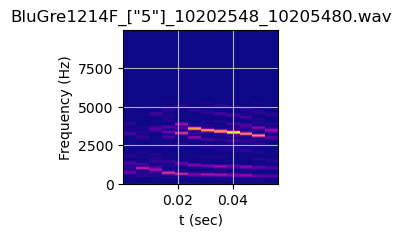


  
cluster_num = 6
raw file name = bird_BroGre1354M_call_["1"]_0.h5
reading a spectrogram from BroGre1354M_["1"]_705034_709502.wav
w is lenght 4468


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


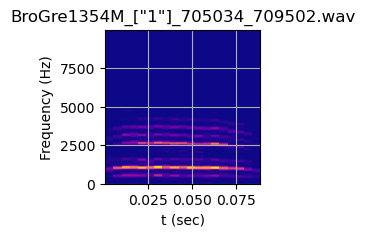


  
raw file name = bird_BroGre1354M_call_["1"]_6.h5
reading a spectrogram from BroGre1354M_["1"]_938688_943405.wav
w is lenght 4717


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


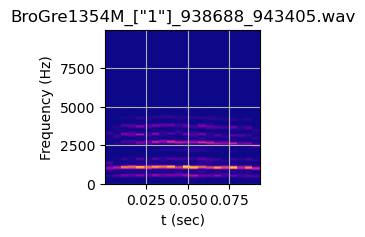


  
raw file name = bird_BroGre1354M_call_["1"]_14.h5
reading a spectrogram from BroGre1354M_["1"]_1467643_1472313.wav
w is lenght 4670


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


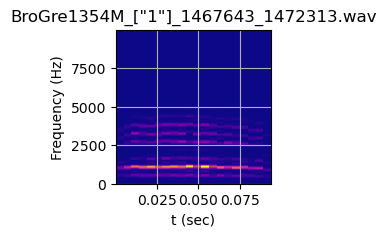


  
raw file name = bird_BroGre1354M_call_["1"]_16.h5
reading a spectrogram from BroGre1354M_["1"]_2093100_2097644.wav
w is lenght 4544


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


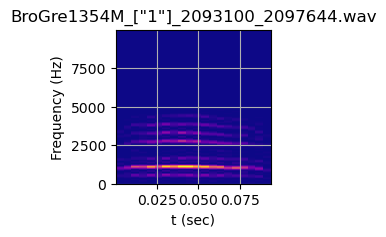


  
cluster_num = 7
raw file name = bird_BroGre1354M_call_["0"]_355.h5
reading a spectrogram from BroGre1354M_["0"]_23140747_23146099.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 5352


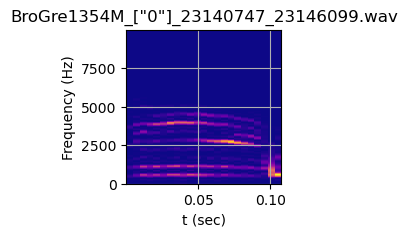


  
raw file name = bird_BluGre1214F_call_["6"]_1674.h5
reading a spectrogram from BluGre1214F_["6"]_84746129_84750599.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 4470


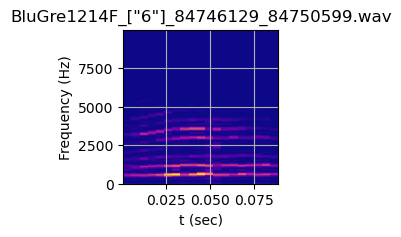


  
raw file name = bird_WhiWhi6607F_call_["6"]_2264.h5
reading a spectrogram from WhiWhi6607F_["6"]_131053936_131060111.wav
w is lenght 6175


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


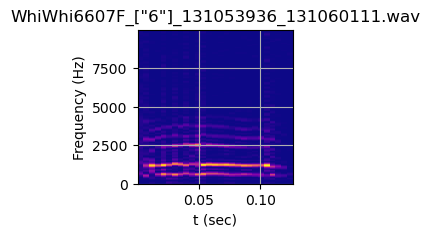


  
raw file name = bird_BroGre1354M_call_["5"]_2563.h5
reading a spectrogram from BroGre1354M_["5"]_145713155_145721332.wav
w is lenght 8177


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


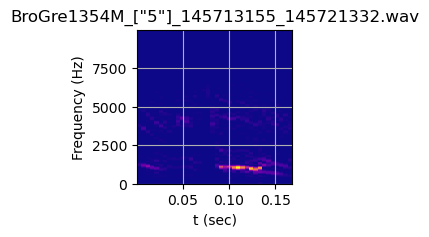


  
cluster_num = 8
raw file name = bird_WhiWhi1541M_call_["3"]_109.h5
reading a spectrogram from WhiWhi1541M_["3"]_6989934_6996392.wav
w is lenght 6458


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


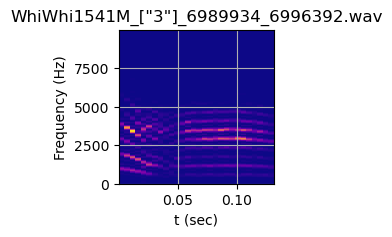


  
raw file name = bird_BluGre1214F_call_["2"]_471.h5
reading a spectrogram from BluGre1214F_["2"]_26021431_26024557.wav
w is lenght 3126


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


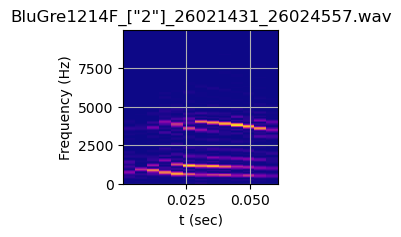


  
raw file name = bird_BroGre1354M_call_["6"]_1130.h5
reading a spectrogram from BroGre1354M_["6"]_57033737_57037272.wav
w is lenght 3535


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


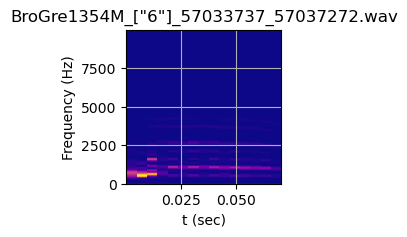


  
raw file name = bird_WhiWhi6607F_call_["1"]_1142.h5
reading a spectrogram from WhiWhi6607F_["1"]_57351466_57367217.wav
w is lenght 15751


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


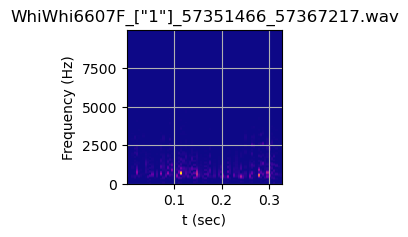


  
cluster_num = 9
raw file name = bird_WhiWhi1541M_call_["6"]_195.h5
reading a spectrogram from WhiWhi1541M_["6"]_9041384_9044744.wav
w is lenght 3360


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


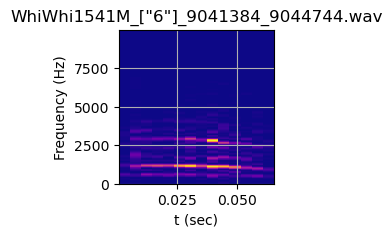


  
raw file name = bird_WhiWhi1541M_call_["6"]_198.h5
reading a spectrogram from WhiWhi1541M_["6"]_9106606_9109763.wav
w is lenght 3157


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


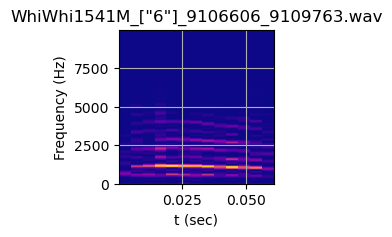


  
raw file name = bird_BroGre1354M_call_["6"]_331.h5
reading a spectrogram from BroGre1354M_["6"]_21562770_21567616.wav
w is lenght 4846


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


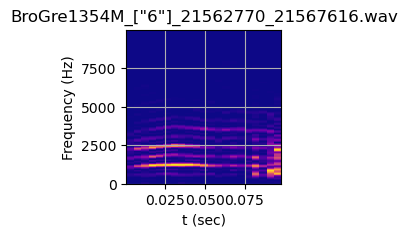


  
raw file name = bird_WhiWhi1541M_call_["6"]_426.h5
reading a spectrogram from WhiWhi1541M_["6"]_24609236_24612198.wav
w is lenght 2962


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


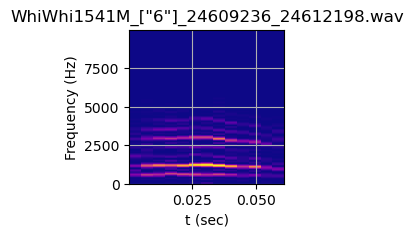


  
cluster_num = 10
raw file name = bird_BroGre1354M_call_["6"]_61.h5
reading a spectrogram from BroGre1354M_["6"]_4942444_4946398.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 3954


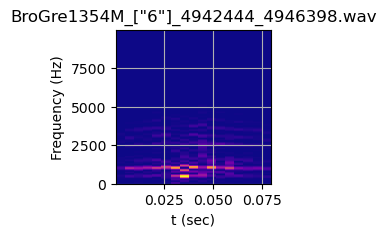


  
raw file name = bird_BroGre1354M_call_["6"]_187.h5
reading a spectrogram from BroGre1354M_["6"]_8836175_8841950.wav
w is lenght 5775


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


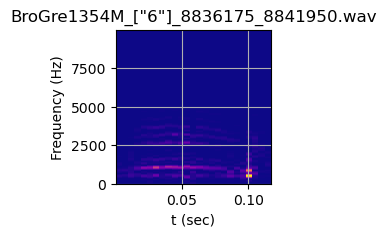


  
raw file name = bird_BroGre1354M_call_["6"]_272.h5
reading a spectrogram from BroGre1354M_["6"]_11573812_11577111.wav
w is lenght 3299


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


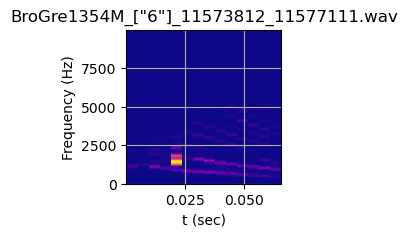


  
raw file name = bird_WhiWhi1541M_call_["6"]_273.h5
reading a spectrogram from WhiWhi1541M_["6"]_11580918_11591247.wav
w is lenght 10329


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


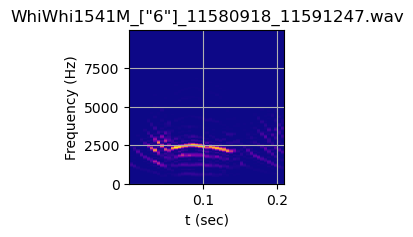


  
cluster_num = 11
raw file name = bird_WhiWhi1541M_call_["6"]_88.h5
reading a spectrogram from WhiWhi1541M_["6"]_6698927_6701567.wav
w is lenght 2640


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


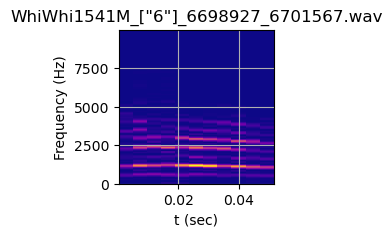


  
raw file name = bird_BluGre1214F_call_["4"]_1157.h5
reading a spectrogram from BluGre1214F_["4"]_57899216_57902331.wav
w is lenght 3115


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


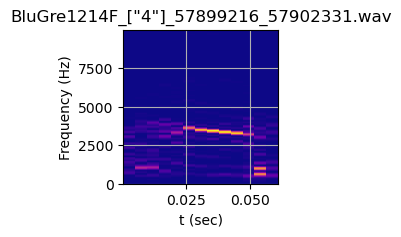


  
raw file name = bird_BroGre1354M_call_["5"]_1425.h5
reading a spectrogram from BroGre1354M_["5"]_77710951_77719661.wav
w is lenght 8710


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


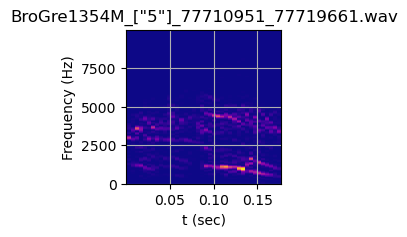


  
raw file name = bird_WhiWhi6607F_call_["0"]_1725.h5
reading a spectrogram from WhiWhi6607F_["0"]_87982194_87987279.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 5085


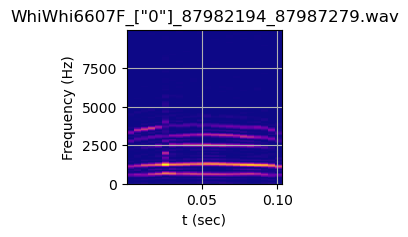


  
cluster_num = 12
raw file name = bird_WhiWhi6607F_call_["6"]_94.h5
reading a spectrogram from WhiWhi6607F_["6"]_6755636_6765173.wav
w is lenght 9537


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


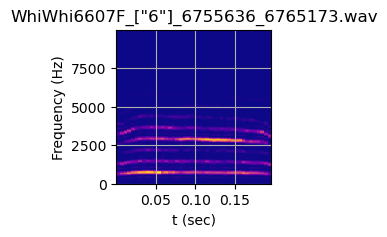


  
raw file name = bird_WhiWhi6607F_call_["6"]_105.h5
reading a spectrogram from WhiWhi6607F_["6"]_6922323_6932018.wav
w is lenght 9695


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


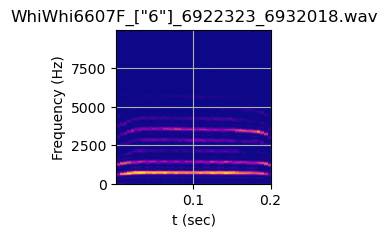


  
raw file name = bird_WhiWhi6607F_call_["6"]_116.h5
reading a spectrogram from WhiWhi6607F_["6"]_7213176_7223597.wav
w is lenght 10421


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


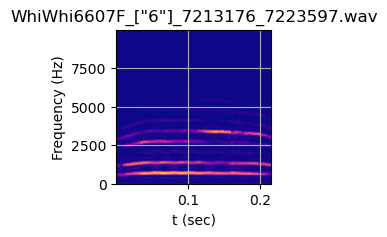


  
raw file name = bird_WhiWhi6607F_call_["6"]_360.h5
reading a spectrogram from WhiWhi6607F_["6"]_23189152_23196718.wav
w is lenght 7566


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


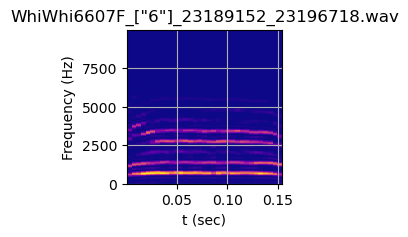


  
cluster_num = 13
raw file name = bird_WhiWhi6607F_call_["6"]_249.h5
reading a spectrogram from WhiWhi6607F_["6"]_10276632_10282018.wav
w is lenght 5386


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


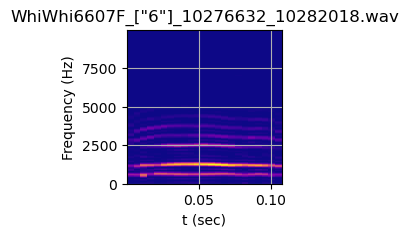


  
raw file name = bird_WhiWhi6607F_call_["0"]_832.h5
reading a spectrogram from WhiWhi6607F_["0"]_40946830_40955934.wav
w is lenght 9104


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


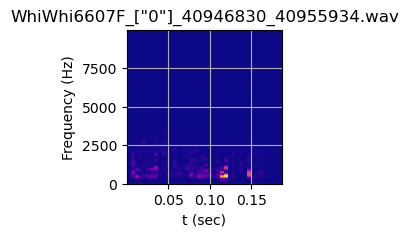


  
raw file name = bird_WhiWhi1541M_call_["5"]_837.h5
reading a spectrogram from WhiWhi1541M_["5"]_41077325_41079868.wav
w is lenght 2543


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


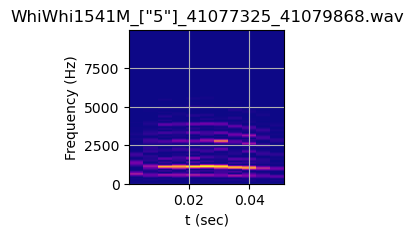


  
raw file name = bird_BroGre1354M_call_["1"]_846.h5
reading a spectrogram from BroGre1354M_["1"]_41269375_41279552.wav
w is lenght 10177


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


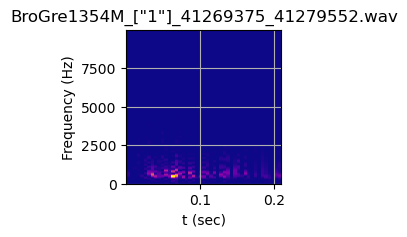


  
cluster_num = 14
raw file name = bird_BroGre1354M_call_["4"]_10.h5
reading a spectrogram from BroGre1354M_["4"]_1169083_1174072.wav
w is lenght 4989


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


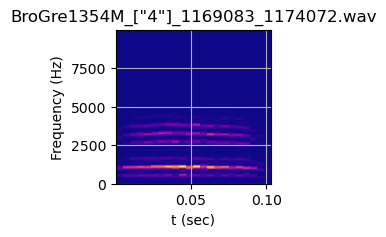


  
raw file name = bird_BroGre1354M_call_["4"]_38.h5
reading a spectrogram from BroGre1354M_["4"]_4328763_4332800.wav
w is lenght 4037


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


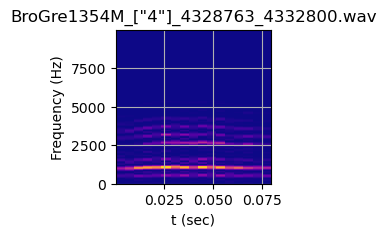


  
raw file name = bird_BroGre1354M_call_["4"]_124.h5
reading a spectrogram from BroGre1354M_["4"]_7583826_7588360.wav
w is lenght 4534


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


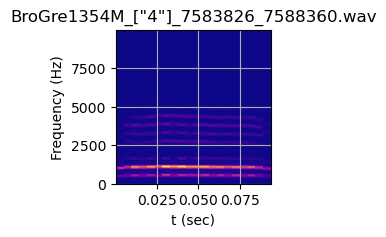


  
raw file name = bird_BroGre1354M_call_["4"]_144.h5
reading a spectrogram from BroGre1354M_["4"]_8066162_8070995.wav
w is lenght 4833


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


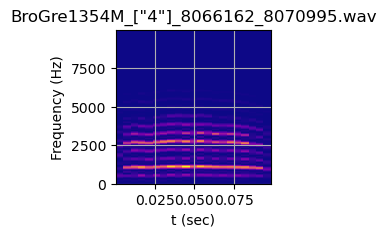


  
cluster_num = 15
raw file name = bird_BroGre1354M_call_["5"]_4.h5
reading a spectrogram from BroGre1354M_["5"]_910549_913839.wav
w is lenght 3290


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


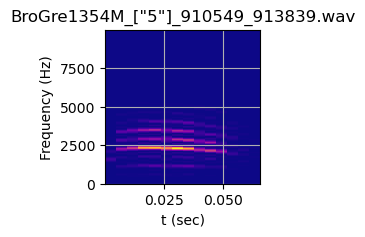


  
raw file name = bird_WhiWhi1541M_call_["5"]_65.h5
reading a spectrogram from WhiWhi1541M_["5"]_5090914_5096497.wav
w is lenght 5583


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


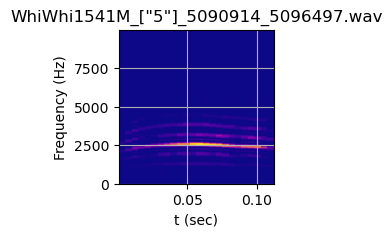


  
raw file name = bird_WhiWhi1541M_call_["5"]_71.h5
reading a spectrogram from WhiWhi1541M_["5"]_5287828_5291494.wav
w is lenght 3666


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


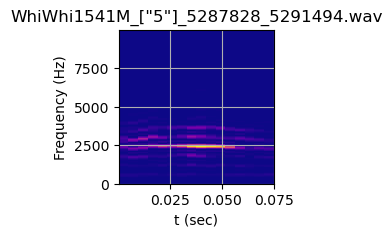


  
raw file name = bird_BroGre1354M_call_["5"]_78.h5
reading a spectrogram from BroGre1354M_["5"]_6098242_6101841.wav
w is lenght 3599


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


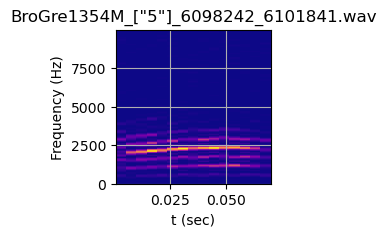


  
cluster_num = 16
raw file name = bird_WhiWhi6607F_call_["6"]_120.h5
reading a spectrogram from WhiWhi6607F_["6"]_7455566_7463209.wav
w is lenght 7643


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


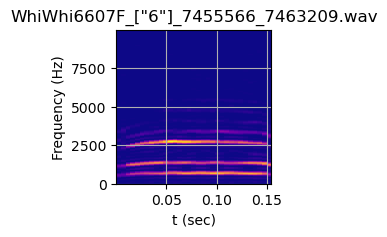


  
raw file name = bird_WhiWhi6607F_call_["6"]_162.h5
reading a spectrogram from WhiWhi6607F_["6"]_8359442_8365252.wav
w is lenght 5810


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


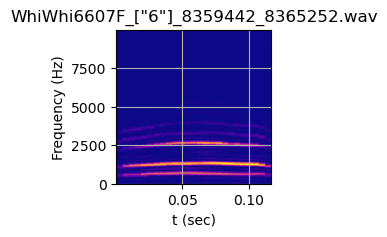


  
raw file name = bird_WhiWhi6607F_call_["6"]_245.h5
reading a spectrogram from WhiWhi6607F_["6"]_10176347_10182535.wav
w is lenght 6188


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


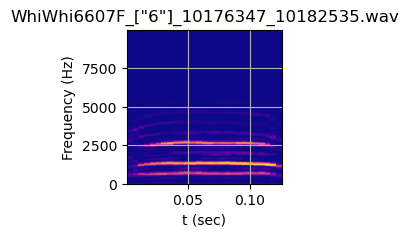


  
raw file name = bird_BluGre1214F_call_["6"]_474.h5
reading a spectrogram from BluGre1214F_["6"]_26046040_26048873.wav
w is lenght 2833


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


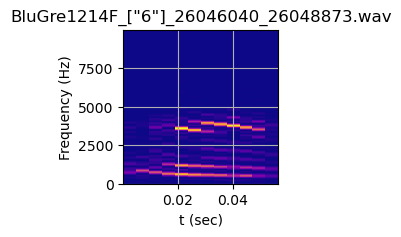


  
cluster_num = 17
raw file name = bird_WhiWhi6607F_call_["6"]_132.h5
reading a spectrogram from WhiWhi6607F_["6"]_7789312_7795631.wav
w is lenght 6319


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


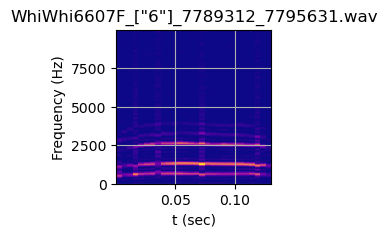


  
raw file name = bird_BroGre1354M_call_["4"]_628.h5
reading a spectrogram from BroGre1354M_["4"]_31105884_31110635.wav
w is lenght 4751


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


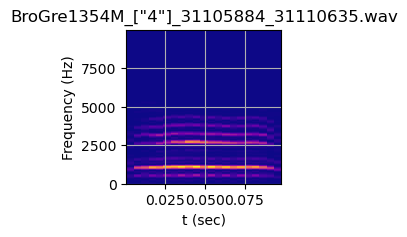


  
raw file name = bird_BluGre1214F_call_["6"]_632.h5
reading a spectrogram from BluGre1214F_["6"]_31182895_31188109.wav
w is lenght 5214


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


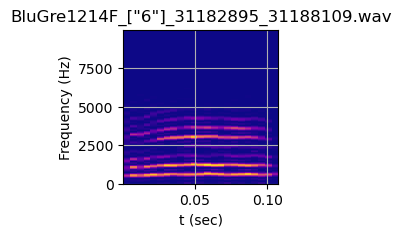


  
raw file name = bird_BluGre1214F_call_["6"]_739.h5
reading a spectrogram from BluGre1214F_["6"]_34473979_34478825.wav
w is lenght 4846


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


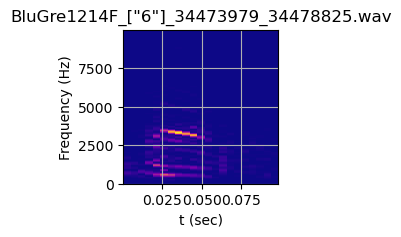


  
cluster_num = 18
raw file name = bird_WhiWhi6607F_call_["6"]_122.h5
reading a spectrogram from WhiWhi6607F_["6"]_7570983_7576219.wav
w is lenght 5236


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


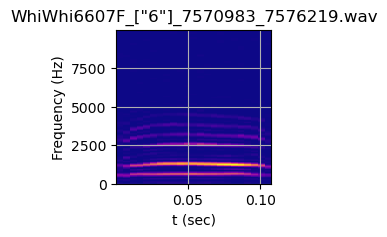


  
raw file name = bird_WhiWhi6607F_call_["6"]_152.h5
reading a spectrogram from WhiWhi6607F_["6"]_8205761_8211334.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 5573


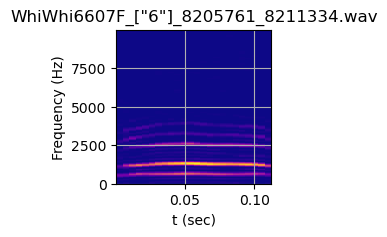


  
raw file name = bird_WhiWhi6607F_call_["6"]_165.h5
reading a spectrogram from WhiWhi6607F_["6"]_8414140_8419583.wav
w is lenght 5443


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


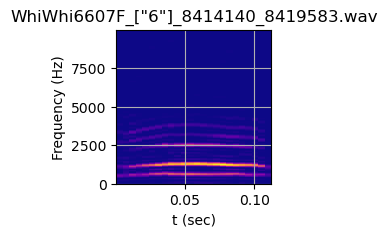


  
raw file name = bird_WhiWhi6607F_call_["6"]_169.h5
reading a spectrogram from WhiWhi6607F_["6"]_8498766_8504264.wav
w is lenght 5498


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


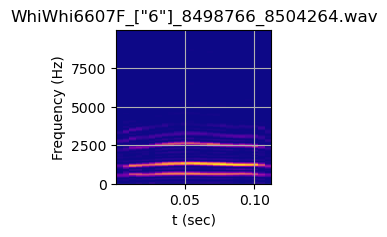


  
cluster_num = 19
raw file name = bird_BroGre1354M_call_["5"]_291.h5
reading a spectrogram from BroGre1354M_["5"]_15954903_15959184.wav
w is lenght 4281


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


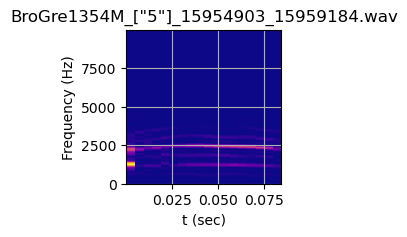


  
raw file name = bird_BroGre1354M_call_["5"]_773.h5
reading a spectrogram from BroGre1354M_["5"]_37864788_37869711.wav
w is lenght 4923


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


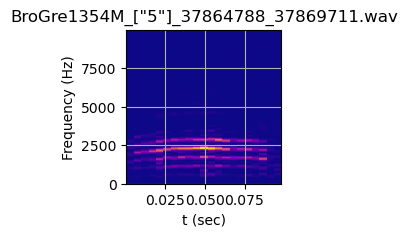


  
raw file name = bird_BluGre1214F_call_["6"]_1283.h5
reading a spectrogram from BluGre1214F_["6"]_72380179_72384548.wav
w is lenght 4369


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


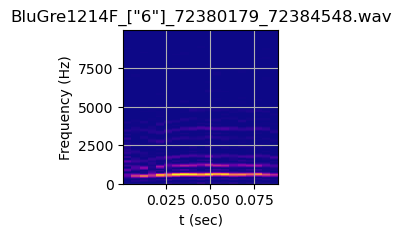

/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]



  
raw file name = bird_BroGre1354M_call_["5"]_1295.h5
reading a spectrogram from BroGre1354M_["5"]_72658996_72667115.wav
w is lenght 8119


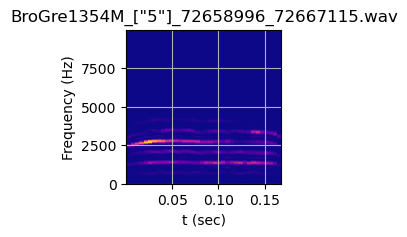


  
cluster_num = 20
raw file name = bird_WhiWhi1541M_call_["5"]_215.h5
reading a spectrogram from WhiWhi1541M_["5"]_9502739_9505334.wav
w is lenght 2595


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


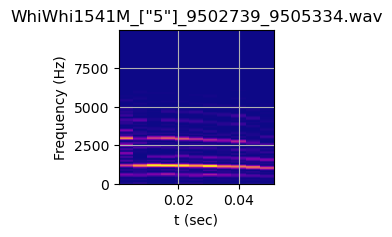


  
raw file name = bird_WhiWhi1541M_call_["5"]_230.h5
reading a spectrogram from WhiWhi1541M_["5"]_9842736_9846014.wav
w is lenght 3278


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


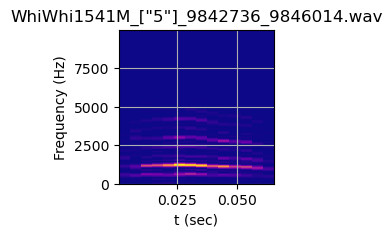


  
raw file name = bird_WhiWhi6607F_call_["0"]_259.h5
reading a spectrogram from WhiWhi6607F_["0"]_10619555_10625064.wav
w is lenght 5509


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


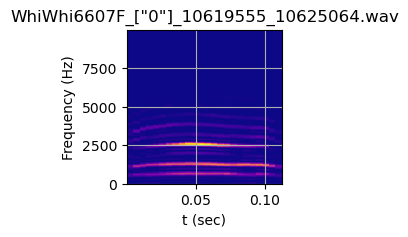


  
raw file name = bird_WhiWhi6607F_call_["5"]_328.h5
reading a spectrogram from WhiWhi6607F_["5"]_21505055_21510208.wav
w is lenght 5153


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


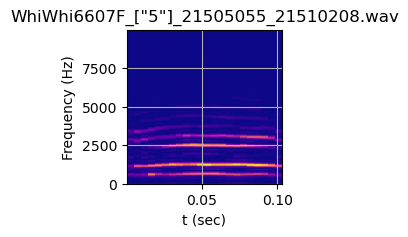


  
cluster_num = 21
raw file name = bird_WhiWhi1541M_call_["5"]_40.h5
reading a spectrogram from WhiWhi1541M_["5"]_4416575_4419371.wav
w is lenght 2796


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


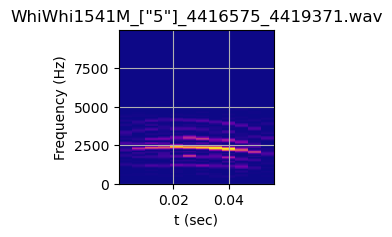


  
raw file name = bird_BroGre1354M_call_["5"]_45.h5
reading a spectrogram from BroGre1354M_["5"]_4501762_4504250.wav
w is lenght 2488


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


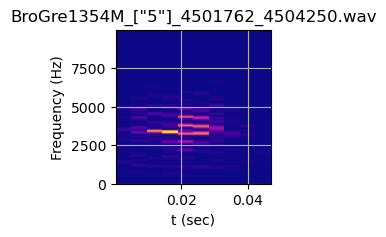


  
raw file name = bird_BroGre1354M_call_["5"]_148.h5
reading a spectrogram from BroGre1354M_["5"]_8145412_8148205.wav
w is lenght 2793


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


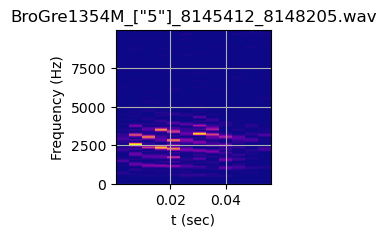


  
raw file name = bird_WhiWhi1541M_call_["5"]_149.h5
reading a spectrogram from WhiWhi1541M_["5"]_8186332_8189135.wav
w is lenght 2803


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


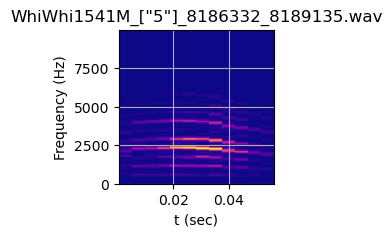


  
cluster_num = 22
raw file name = bird_WhiWhi1541M_call_["5"]_186.h5
reading a spectrogram from WhiWhi1541M_["5"]_8788359_8791798.wav
w is lenght 3439


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


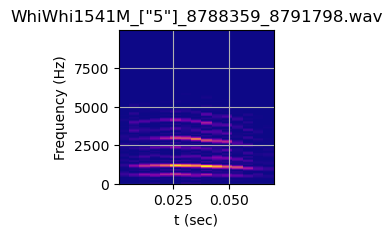


  
raw file name = bird_WhiWhi1541M_call_["5"]_219.h5
reading a spectrogram from WhiWhi1541M_["5"]_9652874_9655986.wav
w is lenght 3112


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


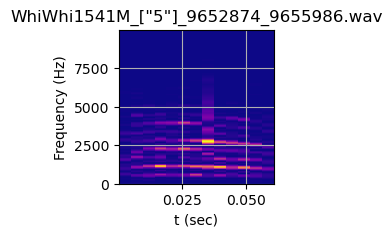


  
raw file name = bird_WhiWhi1541M_call_["5"]_227.h5
reading a spectrogram from WhiWhi1541M_["5"]_9802170_9805570.wav
w is lenght 3400


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


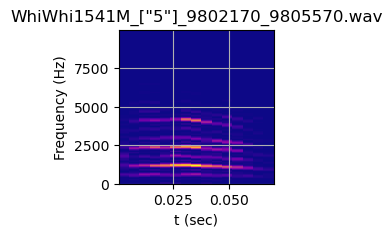


  
raw file name = bird_BroGre1354M_call_["5"]_422.h5
reading a spectrogram from BroGre1354M_["5"]_24567444_24568872.wav
w is lenght 1428


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


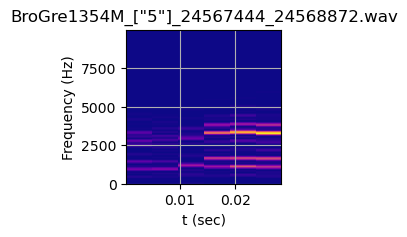


  
cluster_num = 23
raw file name = bird_BroGre1354M_call_["5"]_529.h5
reading a spectrogram from BroGre1354M_["5"]_27916249_27924172.wav
w is lenght 7923


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


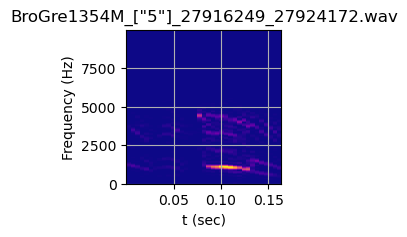


  
raw file name = bird_WhiWhi6607F_call_["6"]_1349.h5
reading a spectrogram from WhiWhi6607F_["6"]_76356309_76362672.wav
w is lenght 6363


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


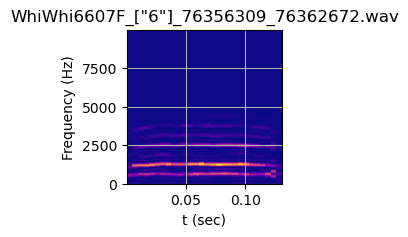


  
raw file name = bird_WhiWhi6607F_call_["6"]_1512.h5
reading a spectrogram from WhiWhi6607F_["6"]_80010385_80014973.wav
w is lenght 4588


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


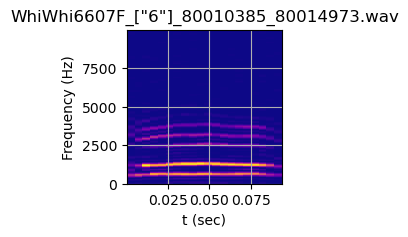


  
raw file name = bird_BluGre1214F_call_["6"]_1519.h5
reading a spectrogram from BluGre1214F_["6"]_80197589_80201238.wav
w is lenght 3649


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


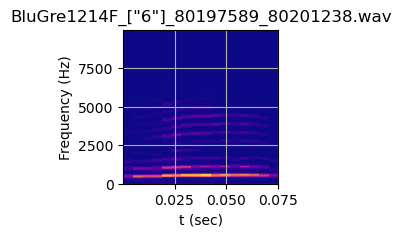


  
cluster_num = 24
raw file name = bird_BluGre1214F_call_["6"]_285.h5
reading a spectrogram from BluGre1214F_["6"]_15368708_15373088.wav
w is lenght 4380


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


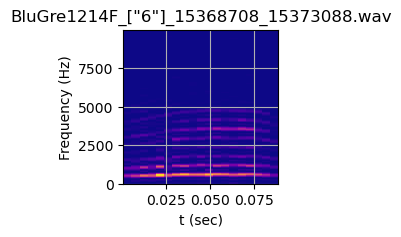


  
raw file name = bird_BluGre1214F_call_["6"]_367.h5
reading a spectrogram from BluGre1214F_["6"]_23306128_23310682.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 4554


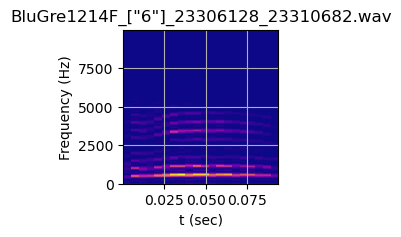


  
raw file name = bird_BluGre1214F_call_["6"]_385.h5
reading a spectrogram from BluGre1214F_["6"]_23843205_23847258.wav
w is lenght 4053


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


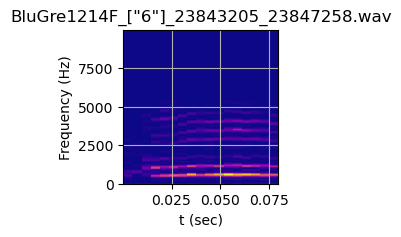


  
raw file name = bird_BluGre1214F_call_["6"]_421.h5
reading a spectrogram from BluGre1214F_["6"]_24556035_24559980.wav
w is lenght 3945


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


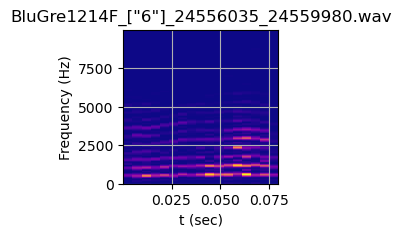


  
cluster_num = 25
raw file name = bird_BluGre1214F_call_["6"]_159.h5
reading a spectrogram from BluGre1214F_["6"]_8312251_8316282.wav
w is lenght 4031


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


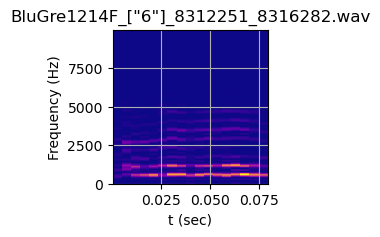


  
raw file name = bird_BluGre1214F_call_["6"]_160.h5
reading a spectrogram from BluGre1214F_["6"]_8333774_8337363.wav
w is lenght 3589


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


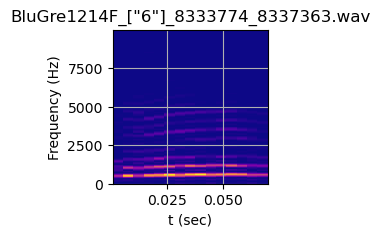


  
raw file name = bird_WhiWhi6607F_call_["6"]_437.h5
reading a spectrogram from WhiWhi6607F_["6"]_25298688_25302387.wav
w is lenght 3699


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


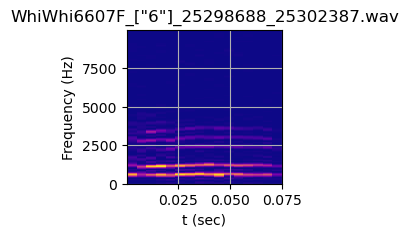


  
raw file name = bird_BluGre1214F_call_["6"]_668.h5
reading a spectrogram from BluGre1214F_["6"]_32382480_32387805.wav
w is lenght 5325


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


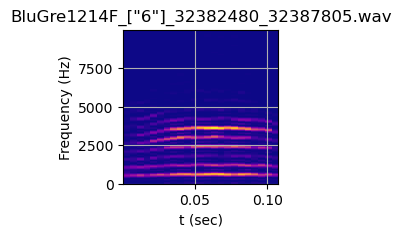


  
cluster_num = 26
raw file name = bird_BroGre1354M_call_["5"]_500.h5
reading a spectrogram from BroGre1354M_["5"]_27344278_27352452.wav
w is lenght 8174


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


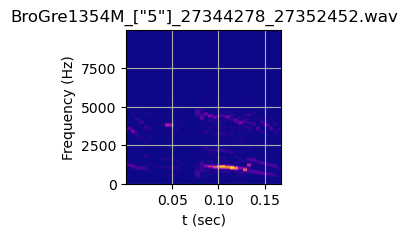


  
raw file name = bird_WhiWhi6607F_call_["6"]_875.h5
reading a spectrogram from WhiWhi6607F_["6"]_41938007_41943791.wav
w is lenght 5784


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


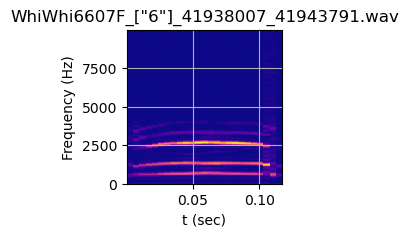


  
raw file name = bird_BroGre1354M_call_["1"]_878.h5
reading a spectrogram from BroGre1354M_["1"]_42021866_42053382.wav
w is lenght 31516


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


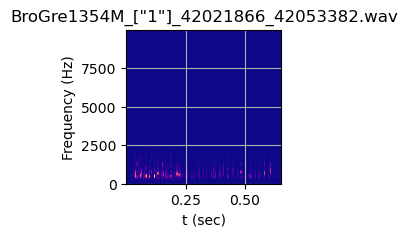


  
raw file name = bird_BluGre1214F_call_["6"]_1091.h5
reading a spectrogram from BluGre1214F_["6"]_51031287_51035844.wav
w is lenght 4557


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


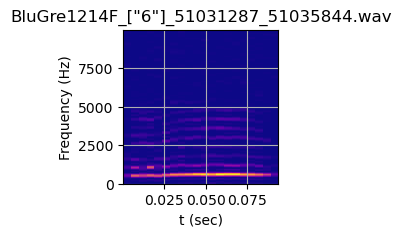


  
cluster_num = 27
raw file name = bird_BluGre1214F_call_["6"]_388.h5
reading a spectrogram from BluGre1214F_["6"]_23925475_23929372.wav
w is lenght 3897


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


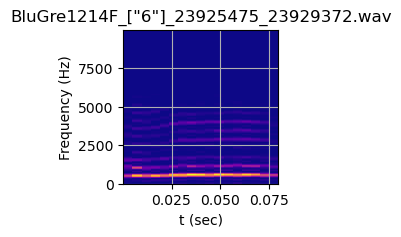


  
raw file name = bird_BluGre1214F_call_["6"]_405.h5
reading a spectrogram from BluGre1214F_["6"]_24350249_24354890.wav
w is lenght 4641


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


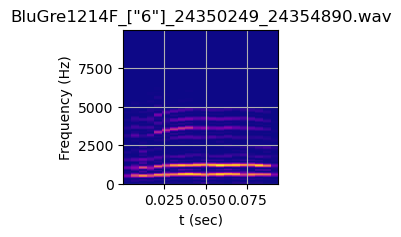


  
raw file name = bird_WhiWhi6607F_call_["1"]_487.h5
reading a spectrogram from WhiWhi6607F_["1"]_27072203_27145105.wav
w is lenght 72902


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


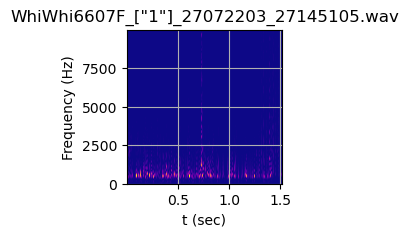


  
raw file name = bird_WhiWhi6607F_call_["6"]_503.h5
reading a spectrogram from WhiWhi6607F_["6"]_27418179_27421031.wav
w is lenght 2852


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


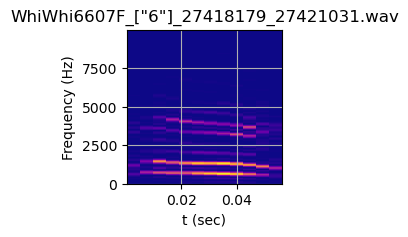


  
cluster_num = 28
raw file name = bird_BluGre1214F_call_["6"]_82.h5
reading a spectrogram from BluGre1214F_["6"]_6479539_6483588.wav
w is lenght 4049


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


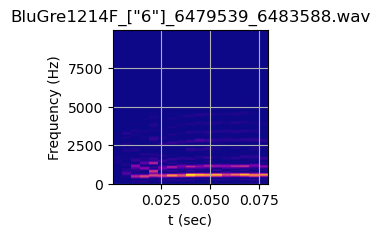


  
raw file name = bird_BluGre1214F_call_["6"]_121.h5
reading a spectrogram from BluGre1214F_["6"]_7561143_7564712.wav
w is lenght 3569


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


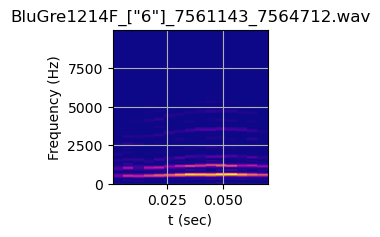


  
raw file name = bird_BluGre1214F_call_["6"]_128.h5
reading a spectrogram from BluGre1214F_["6"]_7702740_7705923.wav
w is lenght 3183


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


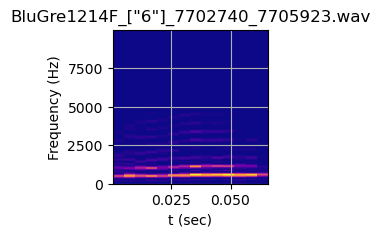


  
raw file name = bird_BluGre1214F_call_["6"]_129.h5
reading a spectrogram from BluGre1214F_["6"]_7718875_7722537.wav
w is lenght 3662


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


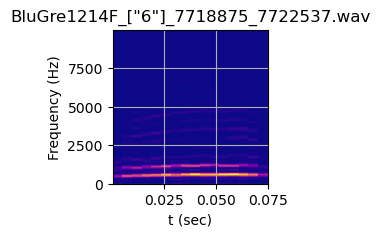


  
cluster_num = 29
raw file name = bird_BluGre1214F_call_["6"]_796.h5
reading a spectrogram from BluGre1214F_["6"]_40355681_40359843.wav
w is lenght 4162


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


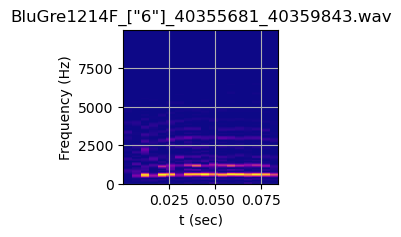


  
raw file name = bird_BroGre1354M_call_["4"]_800.h5
reading a spectrogram from BroGre1354M_["4"]_40433617_40438649.wav
w is lenght 5032


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


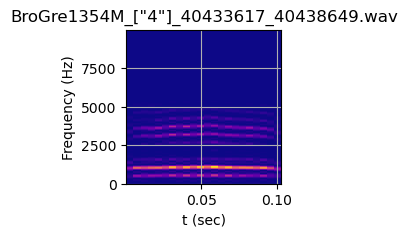


  
raw file name = bird_BroGre1354M_call_["3"]_1158.h5
reading a spectrogram from BroGre1354M_["3"]_57916764_57924601.wav
w is lenght 7837


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


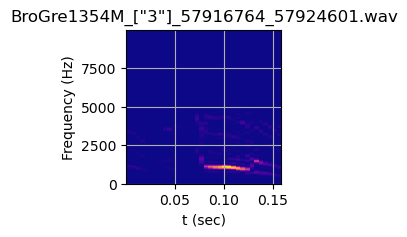


  
raw file name = bird_WhiWhi6607F_call_["6"]_1160.h5
reading a spectrogram from WhiWhi6607F_["6"]_59160314_59165982.wav
w is lenght 5668


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


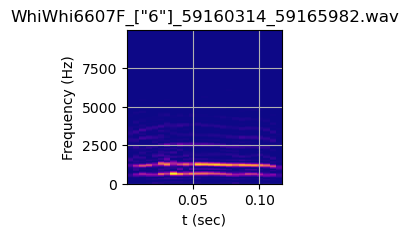


  
cluster_num = 30
raw file name = bird_BluGre1214F_call_["6"]_80.h5
reading a spectrogram from BluGre1214F_["6"]_6349018_6352547.wav
w is lenght 3529


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


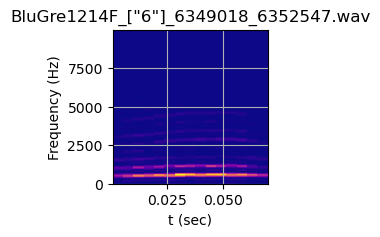


  
raw file name = bird_BluGre1214F_call_["6"]_170.h5
reading a spectrogram from BluGre1214F_["6"]_8522145_8526602.wav
w is lenght 4457


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


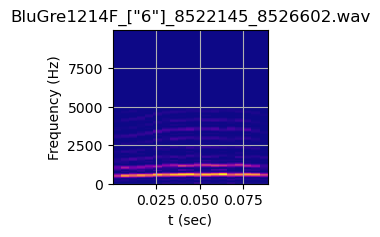


  
raw file name = bird_BluGre1214F_call_["6"]_320.h5
reading a spectrogram from BluGre1214F_["6"]_20056570_20060776.wav
w is lenght 4206


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


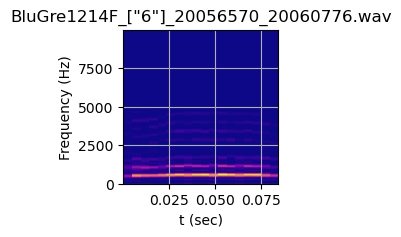


  
raw file name = bird_BluGre1214F_call_["6"]_374.h5
reading a spectrogram from BluGre1214F_["6"]_23514760_23519147.wav
w is lenght 4387


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


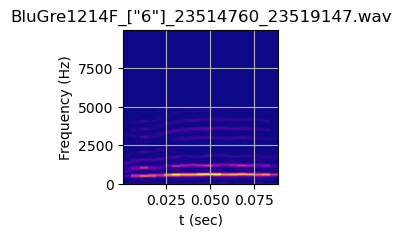


  
cluster_num = 31
raw file name = bird_BroGre1354M_call_["4"]_674.h5
reading a spectrogram from BroGre1354M_["4"]_32655891_32660711.wav
w is lenght 4820


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


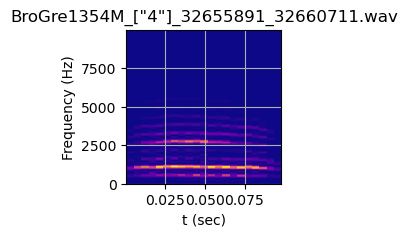


  
raw file name = bird_BluGre1214F_call_["6"]_767.h5
reading a spectrogram from BluGre1214F_["6"]_37574833_37578820.wav
w is lenght 3987


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


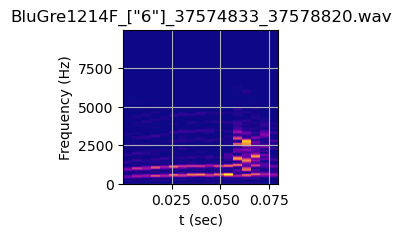


  
raw file name = bird_WhiWhi1541M_call_["5"]_803.h5
reading a spectrogram from WhiWhi1541M_["5"]_40468551_40471468.wav
w is lenght 2917


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


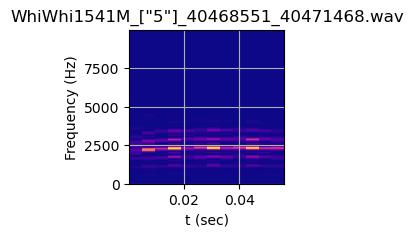


  
raw file name = bird_BluGre1214F_call_["6"]_946.h5
reading a spectrogram from BluGre1214F_["6"]_43982983_43988029.wav
w is lenght 5046


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


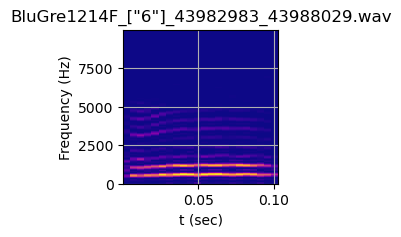


  
cluster_num = 32
raw file name = bird_BluGre1214F_call_["6"]_114.h5
reading a spectrogram from BluGre1214F_["6"]_7180935_7184781.wav
w is lenght 3846


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


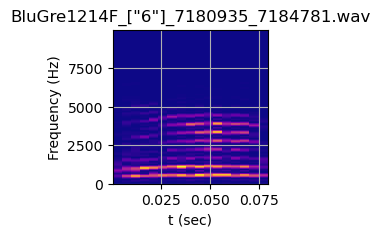


  
raw file name = bird_BroGre1354M_call_["1"]_603.h5
reading a spectrogram from BroGre1354M_["1"]_30004981_30017665.wav
w is lenght 12684


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


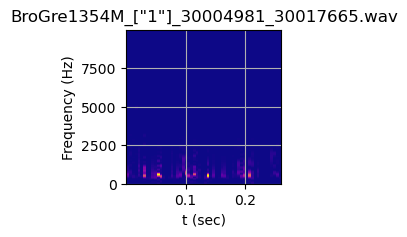


  
raw file name = bird_BroGre1354M_call_["1"]_827.h5
reading a spectrogram from BroGre1354M_["1"]_40863406_40868667.wav
w is lenght 5261


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


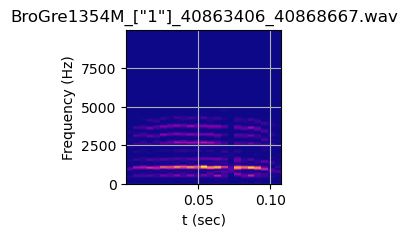


  
raw file name = bird_BluGre1214F_call_["6"]_1351.h5
reading a spectrogram from BluGre1214F_["6"]_76383451_76387715.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 4264


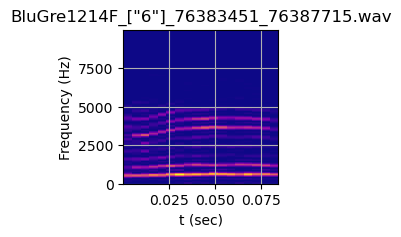


  
cluster_num = 33
raw file name = bird_BluGre1214F_call_["6"]_363.h5
reading a spectrogram from BluGre1214F_["6"]_23235958_23240705.wav
w is lenght 4747


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


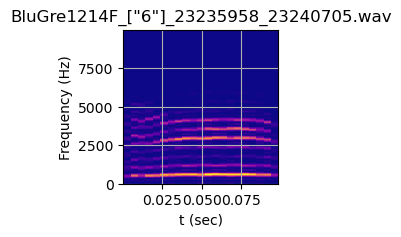


  
raw file name = bird_BroGre1354M_call_["1"]_495.h5
reading a spectrogram from BroGre1354M_["1"]_27282070_27286721.wav
w is lenght 4651


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


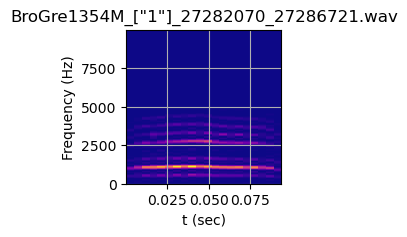


  
raw file name = bird_WhiWhi6607F_call_["6"]_506.h5
reading a spectrogram from WhiWhi6607F_["6"]_27467263_27470163.wav
w is lenght 2900


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


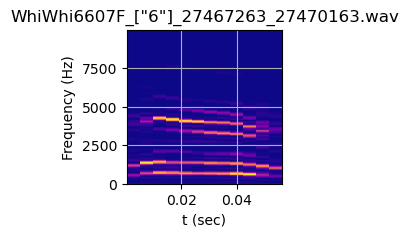


  
raw file name = bird_BroGre1354M_call_["5"]_606.h5
reading a spectrogram from BroGre1354M_["5"]_30044305_30050430.wav
w is lenght 6125


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


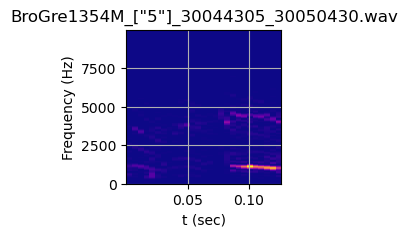


  
cluster_num = 34
raw file name = bird_WhiWhi6607F_call_["6"]_347.h5
reading a spectrogram from WhiWhi6607F_["6"]_23070025_23081338.wav
w is lenght 11313


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


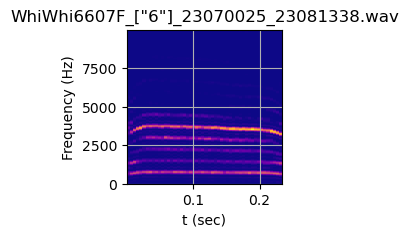


  
raw file name = bird_WhiWhi6607F_call_["6"]_353.h5
reading a spectrogram from WhiWhi6607F_["6"]_23120407_23133551.wav
w is lenght 13144


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


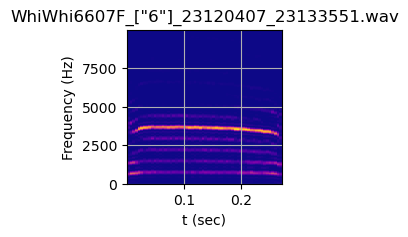


  
raw file name = bird_BluGre1214F_call_["5"]_1010.h5
reading a spectrogram from BluGre1214F_["5"]_46283420_46287167.wav
w is lenght 3747


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


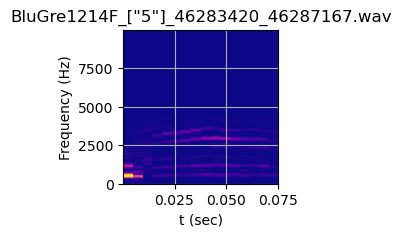


  
raw file name = bird_BroGre1354M_call_["6"]_1012.h5
reading a spectrogram from BroGre1354M_["6"]_46331054_46345861.wav
w is lenght 14807


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


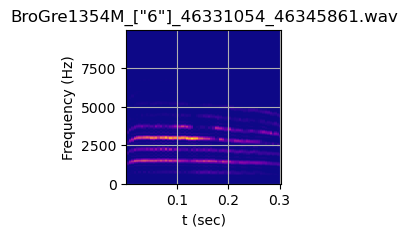


  
cluster_num = 35
raw file name = bird_BluGre1214F_call_["6"]_155.h5
reading a spectrogram from BluGre1214F_["6"]_8284013_8286997.wav
w is lenght 2984


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


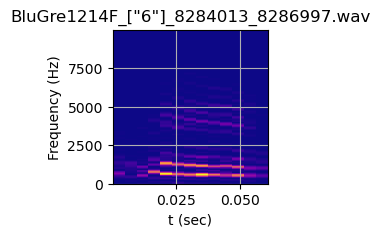


  
raw file name = bird_BluGre1214F_call_["6"]_313.h5
reading a spectrogram from BluGre1214F_["6"]_19848740_19851832.wav
w is lenght 3092


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


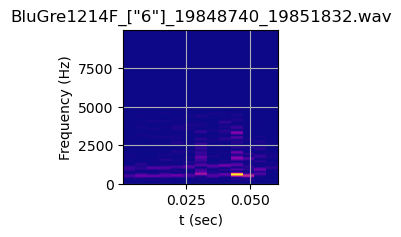


  
raw file name = bird_BluGre1214F_call_["6"]_686.h5
reading a spectrogram from BluGre1214F_["6"]_33300713_33305260.wav
w is lenght 4547


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


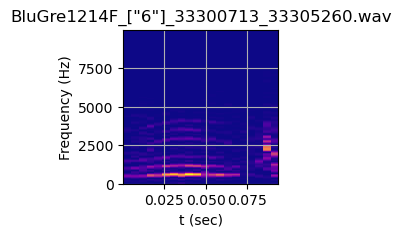


  
raw file name = bird_WhiWhi1541M_call_["5"]_688.h5
reading a spectrogram from WhiWhi1541M_["5"]_33314251_33316950.wav
w is lenght 2699


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


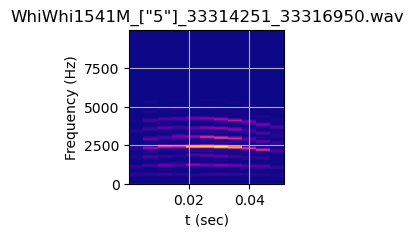


  
cluster_num = 36
raw file name = bird_BluGre1214F_call_["6"]_411.h5
reading a spectrogram from BluGre1214F_["6"]_24418037_24422474.wav
w is lenght 4437


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


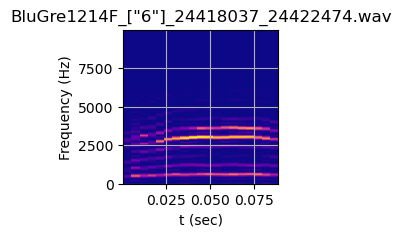


  
raw file name = bird_WhiWhi1541M_call_["6"]_492.h5
reading a spectrogram from WhiWhi1541M_["6"]_27208946_27212199.wav
w is lenght 3253


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


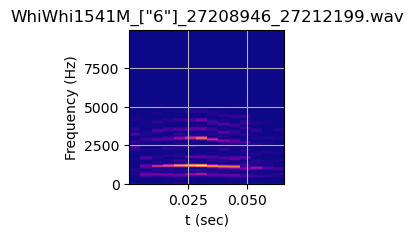


  
raw file name = bird_WhiWhi6607F_call_["6"]_728.h5
reading a spectrogram from WhiWhi6607F_["6"]_34143076_34152402.wav
w is lenght 9326


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


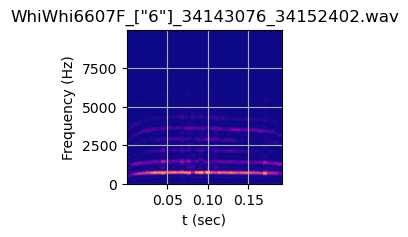


  
raw file name = bird_BluGre1214F_call_["6"]_876.h5
reading a spectrogram from BluGre1214F_["6"]_41947432_41952830.wav
w is lenght 5398


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


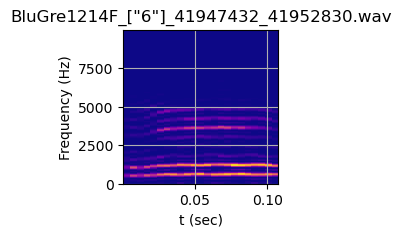


  
cluster_num = 37
raw file name = bird_BluGre1214F_call_["1"]_513.h5
reading a spectrogram from BluGre1214F_["1"]_27552853_27566796.wav
w is lenght 13943


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


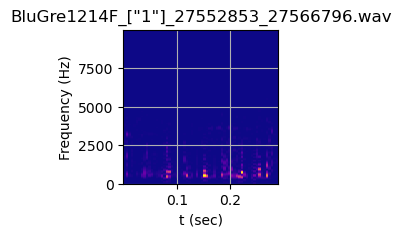


  
raw file name = bird_BluGre1214F_call_["0"]_1009.h5
reading a spectrogram from BluGre1214F_["0"]_46265786_46270702.wav
w is lenght 4916


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


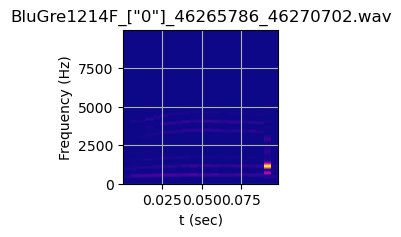


  
raw file name = bird_BluGre1214F_call_["6"]_1632.h5
reading a spectrogram from BluGre1214F_["6"]_83015256_83021775.wav
w is lenght 6519


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


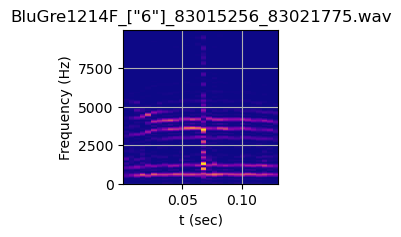


  
raw file name = bird_BluGre1214F_call_["6"]_2050.h5
reading a spectrogram from BluGre1214F_["6"]_123391114_123396117.wav
w is lenght 5003


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


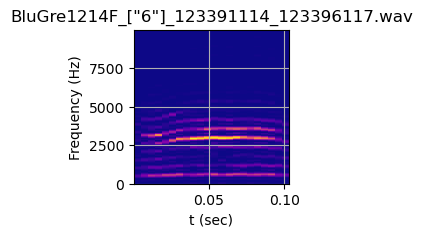


  
cluster_num = 38
raw file name = bird_BluGre1214F_call_["6"]_1.h5
reading a spectrogram from BluGre1214F_["6"]_739121_741816.wav
w is lenght 2695


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


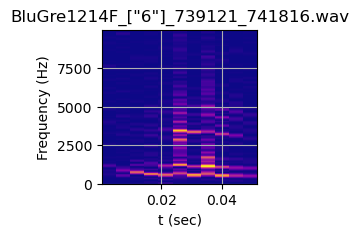


  
raw file name = bird_BluGre1214F_call_["6"]_3.h5
reading a spectrogram from BluGre1214F_["6"]_844891_848558.wav
w is lenght 3667


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


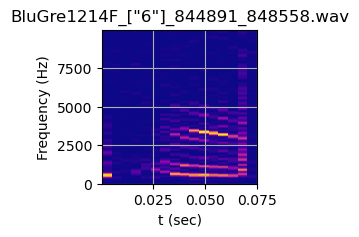


  
raw file name = bird_BluGre1214F_call_["6"]_9.h5
reading a spectrogram from BluGre1214F_["6"]_1047560_1050258.wav
w is lenght 2698


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


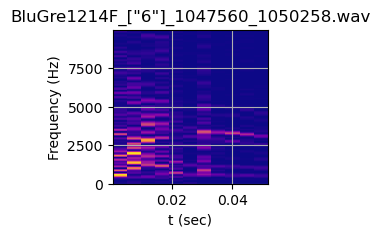


  
raw file name = bird_BluGre1214F_call_["6"]_12.h5
reading a spectrogram from BluGre1214F_["6"]_1303039_1305757.wav
w is lenght 2718


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


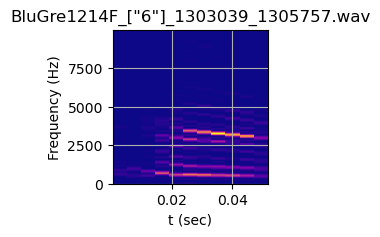


  
cluster_num = 39
raw file name = bird_BluGre1214F_call_["6"]_46.h5
reading a spectrogram from BluGre1214F_["6"]_4573869_4576698.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


w is lenght 2829


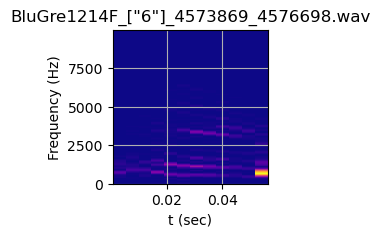


  
raw file name = bird_BluGre1214F_call_["6"]_48.h5
reading a spectrogram from BluGre1214F_["6"]_4622335_4625488.wav
w is lenght 3153


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


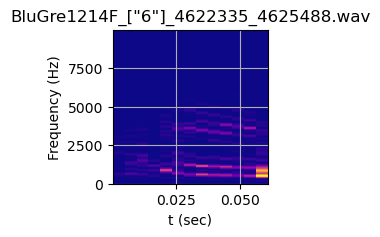


  
raw file name = bird_BluGre1214F_call_["6"]_59.h5
reading a spectrogram from BluGre1214F_["6"]_4881433_4884617.wav
w is lenght 3184


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


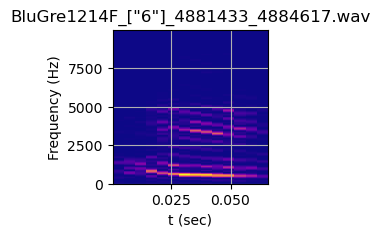


  
raw file name = bird_BluGre1214F_call_["6"]_60.h5
reading a spectrogram from BluGre1214F_["6"]_4889768_4892663.wav
w is lenght 2895


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


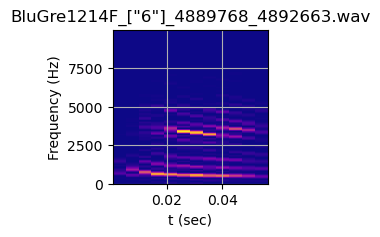


  
cluster_num = 40
raw file name = bird_BluGre1214F_call_["6"]_166.h5
reading a spectrogram from BluGre1214F_["6"]_8426594_8429738.wav
w is lenght 3144


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


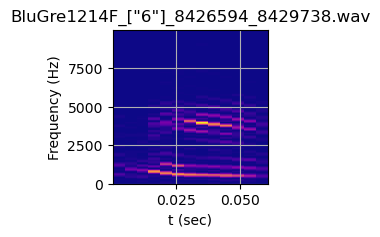


  
raw file name = bird_BluGre1214F_call_["6"]_178.h5
reading a spectrogram from BluGre1214F_["6"]_8639143_8642179.wav
w is lenght 3036


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


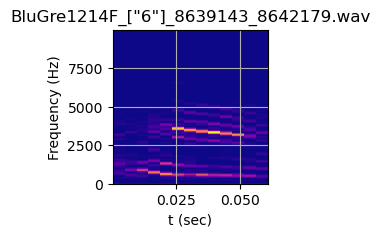


  
raw file name = bird_BluGre1214F_call_["6"]_207.h5
reading a spectrogram from BluGre1214F_["6"]_9341054_9343961.wav
w is lenght 2907


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


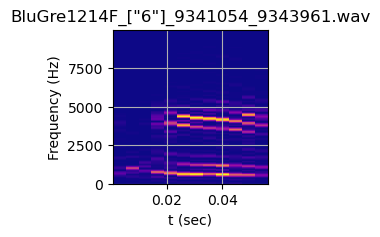


  
raw file name = bird_BluGre1214F_call_["6"]_246.h5
reading a spectrogram from BluGre1214F_["6"]_10186565_10189569.wav
w is lenght 3004


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/2878755991.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


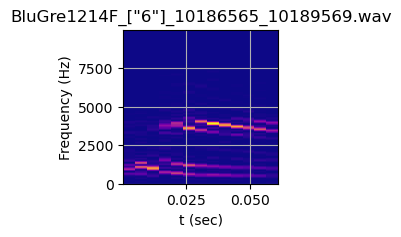

In [38]:
# plot some spectrograms from each cluster
# get the indices of the calls in each cluster
# cluster 0
num_to_plot = 4
for cluster_num in np.unique(clusterer.labels_):
    print(f'cluster_num = {cluster_num}')
    cluster_indices = np.where(clusterer.labels_ == cluster_num)
    # print(f'cluster_indices = {cluster_indices}')
    # get the first num_to_plot calls in the cluster
    for i in range(num_to_plot):
        # print(f'cluster {cluster_num}, call {i}')
        # print(f'index = {cluster_indices[0][i]}')
        print(f'raw file name = {files_list[cluster_indices[0][i]]}')
        # print(f'call type = {vocSelTableFull.iloc[cluster_indices[0][i],2]}')
        # print(f'bird = {vocSelTableFull.iloc[cluster_indices[0][i],0]}')
        # print(f'call length = {vocSelTableFull.iloc[cluster_indices[0][i],-1]}')
        db_ind = {cluster_indices[0][i] }
        # print(f'db_ind = {db_ind}')

        fname = files_list[cluster_indices[0][i]]
        start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
        stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]

        # cut everything after ' "] ' but keep the "]
        fname = fname.split('"]')[0] + '"]'
        fname = f'{fname}_{start_i}_{stop_i}.wav'

        # cut 'call_' in the filename but save everything before and after it
        fname = fname.split('call_')
        fname = f'{fname[0]}{fname[1]}'
        # cut 'bird_' in the filename but save everything after it
        fname = fname.split('bird_')[1]
        # print(f'fname no call = {fname}')
        
        # read wave file using scipy
        print(f"reading a spectrogram from {fname}")
        fs, w = read(os.path.join(base_folder, "wavs", fname))
        print(f"w is lenght {len(w)}")
        # w = read(os. fname)
        # myBioSound = BioSound()
        # myBioSound.readh5(fname)
        # w = myBioSound.wave
        
        plot_a_spectrogram(w, fs=fs, title=fname)
        plt.show()
        # # play the sound
        # ipd.Audio(w, rate=fs)
        print('\n  ')


## Take just the biggest cluster and re-plot it in a new umap space and recluster it and plot those identites


biggest cluster = -1


Text(0.5, 1.0, 'old UMAP of cluster -1')

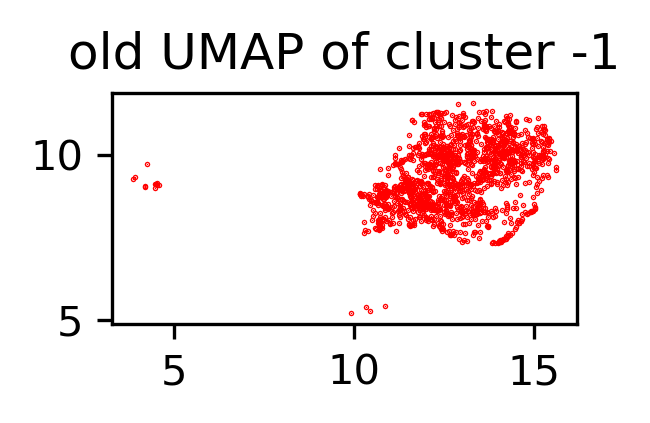

In [42]:
# take the biggest cluster and plot the UMAP of it
biggest_cluster = Counter(clusterer.labels_).most_common(1)[0][0]
print(f'biggest cluster = {biggest_cluster}')
cluster_ind = np.where(clusterer.labels_ == biggest_cluster)[0]

# cluster_ind = np.where(clusterer.labels_ == 7)[0]
cluster_old_umap =  umapAll[cluster_ind,:]
plt.figure(figsize=(2,1), dpi=300)
plt.scatter(cluster_old_umap[:, 0], cluster_old_umap[:, 1], s=0.1, c='r')
plt.title(f"old UMAP of cluster {biggest_cluster}")

Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

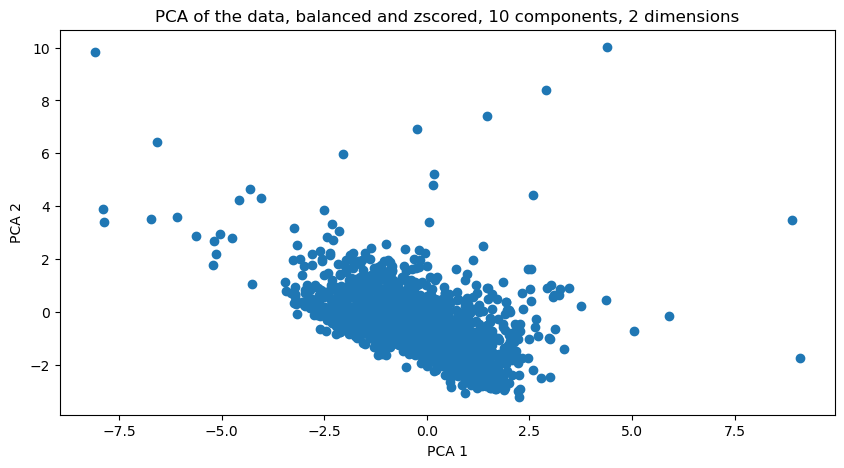

In [43]:
# but let's try making a new umap fit just based on this cluster
cluster_data = Z_PCA_Balanced_All[cluster_ind,:]

# plot it pca space
plt.figure(figsize=(10, 5))
plt.scatter(cluster_data[:,0], cluster_data[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


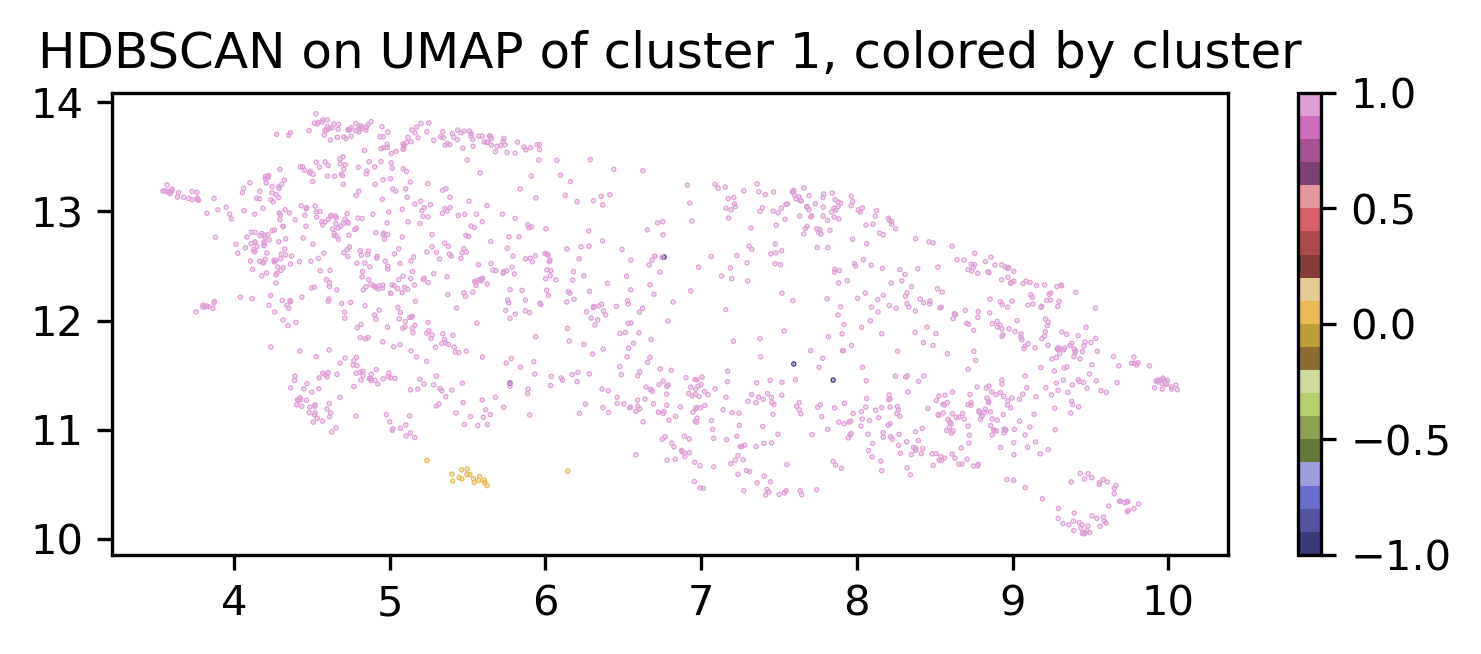

In [44]:
# make a new umap fit
umapFitCluster = umap.UMAP(
        n_neighbors=int(len(cluster_data)/MAXSYLL),
        min_dist=0.1,
        n_components=4,
        random_state=42).fit(cluster_data)

# project the data into the new umap
umapClusterData = umapFitCluster.transform(cluster_data)

# now let's cluster the cluster
min_cluster_size = 15
min_samples = 15
cluster_selection_epsilon = 0.4
clustererCluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)
clustererCluster.fit(umapClusterData)

# Plot the new umap with new clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapClusterData[:, 0], umapClusterData[:, 1], s=0.1, c=clustererCluster.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of cluster 1, colored by cluster')
plt.colorbar()



In [45]:
# print the number of calls in each cluster and the unclassified
print('Number of calls in each cluster and the unclassified')
print(Counter(clustererCluster.labels_))


Number of calls in each cluster and the unclassified
Counter({1: 1453, 0: 17, -1: 4})


## ok, this looks good, let's update our original UMAP with the new cluster labels

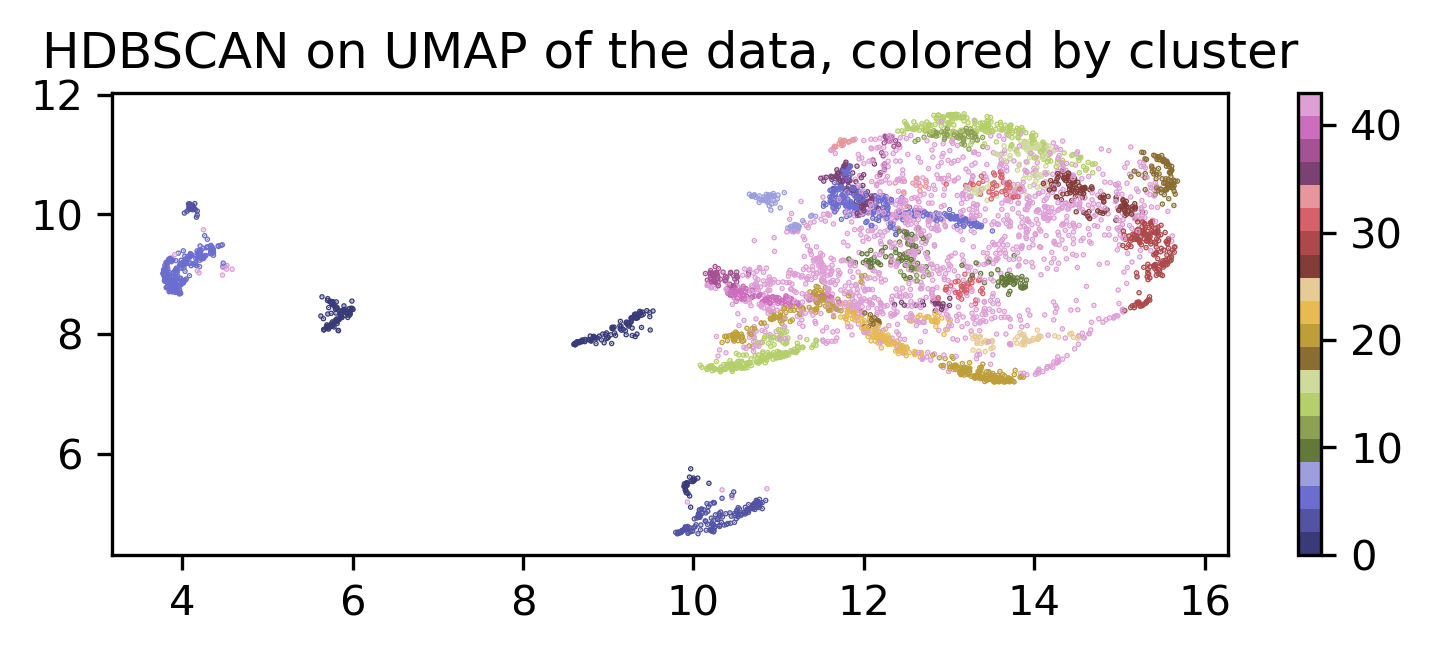

In [46]:
# update the cluster labels
clustererCluster.labels_ += np.max(clusterer.labels_) + 2
clusterer.labels_[cluster_ind] = clustererCluster.labels_
 
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()


In [47]:
vocSelTableFull

Bird calltype        fund   devfund    cvfund     maxfund  \
0     BroGre1354M    ["1"]  508.574590 -0.740855  0.045986  527.472527   
1     BluGre1214F    ["6"]  523.880794 -1.720430  0.011674  533.333333   
2     BluGre1214F    ["2"]  548.575055 -2.208039  0.027101  564.705882   
3     BluGre1214F    ["6"]  557.333804 -2.713336  0.036705  592.592593   
4     BroGre1354M    ["5"]  560.232975 -0.867444  0.035327  578.313253   
...           ...      ...         ...       ...       ...         ...   
4339  WhiWhi1541M    ["5"]  518.037891 -1.209025  0.040681  539.325843   
4340  BluGre1214F    ["6"]  536.911375  0.723694  0.153731  592.592593   
4341  BluGre1214F    ["6"]  567.024101  0.350191  0.102408  600.000000   
4342  BluGre1214F    ["6"]  557.353786  0.768246  0.171243  615.384615   
4343  WhiWhi1541M    ["5"]  549.016050 -1.051440  0.051059  578.313253   

         minfund           F1           F2           F3  ...     kurtT  \
0     436.363636  1664.044399  3561.528246  8596.893613  ...  1.959314   
1     516.129032  3271.703942  6280.586421  9217.829837  ...  2.109855   
2     516.129032  4135.587818  9121.142787          NaN  ...  2.189062   
3     527.472527  3192.273235  6348.161057  9158.343416  ...  2.201422   
4     516.129032  2570.895759  4398.845756  9123.647713  ...  2.304452   
...          ...          ...          ...          ...  ...       ...   
4339  475.247525  1927.627306  3946.935002  9088.130784  ...  2.036406   
4340  298.136646  1827.897792  4833.507703  8912.761732  ...  1.979158   
4341  296.296296  1765.890567  4526.155286  8829.029019  ...  1.894907   
4342  290.909091  1829.396367  4179.381920  8804.060975  ...  2.121620   
4343  489.795918  1623.441547  4200.259348  8997.675394  ...  1.997225   

          entT  Unnamed: 0   SourceName  SourceChannel  StartIndex  StopIndex  \
0     0.989150           0  BroGre1354M              0      705034     709502   
1     0.986979           1  BluGre1214F              2      739121     741816   
2     0.960172           2  BluGre1214F              2      773851     776369   
3     0.982954           3  BluGre1214F              2      844891     848558   
4     0.976569           4  BroGre1354M              0      910549     913839   
...        ...         ...          ...            ...         ...        ...   
4339  0.990364        4339  WhiWhi1541M              3   297302736  297305283   
4340  0.989058        4340  BluGre1214F              2   297324812  297329004   
4341  0.994484        4341  BluGre1214F              2   297367001  297371644   
4342  0.974212        4342  BluGre1214F              2   298070022  298074525   
4343  0.991150        4343  WhiWhi1541M              3   298089447  298092579   

      Tags  cluster  callLength  
0        1      0.0    0.093083  
1        6      5.0    0.056146  
2        2      1.0    0.052458  
3        6      5.0    0.076396  
4        5      4.0    0.068542  
...    ...      ...         ...  
4339     5      4.0    0.053062  
4340     6      5.0    0.087333  
4341     6      5.0    0.096729  
4342     6      5.0    0.093812  
4343     5      4.0    0.065250  

[4344 rows x 34 columns]

In [48]:
# Ok these clusters look ok let's save them to the original df. 
# First we need to add the cluster labels to the original df
vocSelTableFull['new_clusters'] = -2 # add a new column to the df
vocSelTableFull['new_clusters'][indGood] = clusterer.labels_ + 1# add the cluster labels to the new column from the first clustering
vocSelTableFull['new_clusters'][indBad] = -2 # add the unclassified calls to the new column
print('unique new clusters:', np.unique(vocSelTableFull['new_clusters']))

print('Number of calls in each cluster and the unclassified')
print(Counter(vocSelTableFull['new_clusters']))


unique new clusters: [-2  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Number of calls in each cluster and the unclassified
Counter({44: 1453, 7: 295, 6: 260, 15: 186, 16: 175, 4: 150, 21: 130, 23: 117, 31: 116, 22: 110, 2: 102, 1: 89, 19: 84, 37: 80, 17: 78, 11: 69, 27: 69, 40: 66, 39: 58, 13: 56, 28: 54, 10: 49, 9: 43, 33: 40, 32: 34, 26: 31, 5: 30, 3: 30, 41: 29, 30: 22, 29: 21, 24: 21, 25: 20, 36: 18, 35: 18, 8: 18, 38: 18, 43: 17, 12: 17, 18: 16, 14: 16, 34: 16, 20: 15, -2: 4, 42: 4})


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/3771552412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indGood] = clusterer.labels_ + 1# add the cluster labels to the new column from the first clustering
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_33063/3771552412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indBad] = -2 # add the unclassified calls to the new column


In [49]:
# yeah that looks fine. 
# to resave the segments.csv file with the new cluster labels we need to put the new cluster labels back into the segments.csv file
# first we need to get the start and stop indices of the calls that we have in the vocSelTableFull
# we can then use these to replace the cluster labels in the segments.csv file
# we can then save the segments.csv file back to the original location

import json
for i in range(len(vocSelTableFull)):
    start_index = vocSelTableFull['StartIndex'].iloc[i]
    stop_index = vocSelTableFull['StopIndex'].iloc[i]
    cluster_label = vocSelTableFull['new_clusters'].iloc[i]
    syllTable.loc[syllTable['StartIndex'] == start_index, 'Tags'] = json.dumps(list([str(cluster_label)]))

print(len(syllTable))
syllTable.to_csv(syll_file_name, index=False)

# vocSelTableFull.to_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5'), 'callTable', mode = 'w')
# print('File saved to', os.path.join(base_folder, 'vocSelTableAmp.h5'))

4344


In [50]:
# you have to copy and paste these into the tags.csv file
# The unique tags
tags = np.unique(syllTable['Tags'])

# Copy and paste this output to tags.csv
print(',TagName')
i=0
for itag, tag in enumerate(tags):
    print('{},{}'.format(itag, tag[2:-2]))
    # print(tag)
    i+=1

# # Write Labelled file to disk
# syllTable.to_csv(syllableOut)
# print(len(syllTable))
# print(len(vocSelTableFull))

,TagName
0,-2
1,1
2,10
3,11
4,12
5,13
6,14
7,15
8,16
9,17
10,18
11,19
12,2
13,20
14,21
15,22
16,23
17,24
18,25
19,26
20,27
21,28
22,29
23,3
24,30
25,31
26,32
27,33
28,34
29,35
30,36
31,37
32,38
33,39
34,4
35,40
36,41
37,42
38,43
39,44
40,5
41,6
42,7
43,8
44,9


In [ ]:
# # The unique tags
# tags = np.unique(segmentTable['Tags'])

# # Copy and paste this output to tags.csv
# print(',TagName')
# for itag, tag in enumerate(tags):
#     print('{},{}'.format(itag, tag[2:-2]))
    

Unnamed: 0.1  Unnamed: 0   SourceName  SourceChannel  StartIndex  \
0             0           0  BroGre1354M              0      705034   
1             1           1  BluGre1214F              2      739121   
2             2           2  BluGre1214F              2      773851   
3             3           3  BluGre1214F              2      844891   
4             4           4  BroGre1354M              0      910549   

   StopIndex   Tags  cluster  
0     709502  ["1"]      0.0  
1     741816  ["6"]      5.0  
2     776369  ["2"]      1.0  
3     848558  ["6"]      5.0  
4     913839  ["5"]      4.0

In [51]:
project_dir = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
seg_df = pd.read_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))
new_coords = umapAll.astype(float)    # n x 3 array
seg_df['Coords'] = None
seg_df.loc[indGood,'Coords'] = [json.dumps(list(x)) for x in new_coords]
seg_df.to_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))

In [52]:
seg_df.Tags.unique()

array(['["7"]', '["39"]', '["2"]', '["16"]', '["44"]', '["15"]', '["22"]',
       '["40"]', '["43"]', '["6"]', '["11"]', '["31"]', '["29"]',
       '["12"]', '["13"]', '["9"]', '["4"]', '["33"]', '["17"]', '["19"]',
       '["18"]', '["1"]', '["36"]', '["26"]', '["41"]', '["23"]',
       '["10"]', '["21"]', '["14"]', '["25"]', '["20"]', '["35"]',
       '["5"]', '["8"]', '["34"]', '["28"]', '["3"]', '["37"]', '["-2"]',
       '["27"]', '["38"]', '["24"]', '["32"]', '["42"]', '["30"]'],
      dtype=object)

In [53]:
[set([t for t in json.loads(tag_str)]) for tag_str in seg_df.Tags.unique()]

[{'7'},
 {'39'},
 {'2'},
 {'16'},
 {'44'},
 {'15'},
 {'22'},
 {'40'},
 {'43'},
 {'6'},
 {'11'},
 {'31'},
 {'29'},
 {'12'},
 {'13'},
 {'9'},
 {'4'},
 {'33'},
 {'17'},
 {'19'},
 {'18'},
 {'1'},
 {'36'},
 {'26'},
 {'41'},
 {'23'},
 {'10'},
 {'21'},
 {'14'},
 {'25'},
 {'20'},
 {'35'},
 {'5'},
 {'8'},
 {'34'},
 {'28'},
 {'3'},
 {'37'},
 {'-2'},
 {'27'},
 {'38'},
 {'24'},
 {'32'},
 {'42'},
 {'30'}]